# Lebron James 
Purpose: PySpark Hands-on code

Data Preprocessing, Exploratory Data Analysis, Machine Learning

<img src="images/lebronjames.jpeg" alt="Lebron James" width="200" height="250">

In [1]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

plt.rc('figure', figsize=(18, 4))

sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

np.set_printoptions(precision=4, suppress=True)

In [3]:
#import findspark
#findspark.init('/home/sam/spark-2.3.0-bin-hadoop2.7')

In [4]:
spark = SparkSession.builder.appName('lebron').getOrCreate()

In [5]:
data = spark.read.csv('data/LebronJamesRegularSeason.csv', inferSchema = True, header = True)

### Peek at Data 
Lebron James Stats from: www.basketball-reference.com/players/j/jamesle01/gamelog/2018
- Rank (RK)
- Season Game (G)
- Date when Game was played (Date): YYYY-MM-DD
- Age (Age): Year-Day
- Team (Tm)
- column 5: away or home, if @ is present, then Lebron is Away
- Opponent (Opp)
- column 7: W/L (+/- final score difference)
- Game Started (GS): 1/0 
- Minutes Played (MP)
- Field Goal Made (FG)
- Field Goal Attempts (FGA)
- Field Goal Percentage (FG%)
- 3-pt field goals (3P)
- 3-pt field goal attempts (3PA)
- Free throw (FT)
- Free throw attempts (FTA)
- Free throw percentage (FT%)
- Offence Rebound (ORB)
- Defensive Rebound (DRB)
- Total Rebound (TRB)
- Assists (AST)
- Steals (STL)
- Blocks (BLK)
- TurnOver (TOV)
- Personal Fouls (PF)
- Game Score (GmSc): the formula is $$ PTS + 0.4  FG - 0.7 \times FGA - 0.4 \times (FTA - FT) + 0.7 \times ORB + 0.3 \times DRB + STL + 0.7 \times AST + 0.7 \times BLK - 0.4 \times PF - TOV$$ Game Score was created by John Hollinger to give a rough measure of a player's productivity for a single game. The scale is similar to that of points scored, (40 is an outstanding performance, 10 is an average performance, etc.)
- +/-: reflects how well the team did when Lebron was on the court. Ex: +5 means Cavs outscored team by 5 when Lebron was on court

For more definitions go to https://www.basketball-reference.com/about/glossary.html

In [6]:
data.printSchema()

root
 |-- Rk: integer (nullable = true)
 |-- G: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Tm: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- Opp: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- GS: integer (nullable = true)
 |-- MP: string (nullable = true)
 |-- FG: integer (nullable = true)
 |-- FGA: integer (nullable = true)
 |-- FG%: double (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- 3P%: double (nullable = true)
 |-- FT: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- FT%: double (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- TRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- G

In [7]:
data.show(5)

+---+---+--------+------+---+----+---+-------+---+--------+---+---+-----+---+---+-----+---+---+-----+---+---+---+---+---+---+---+---+---+----+---+
| Rk|  G|    Date|   Age| Tm| _c5|Opp|    _c7| GS|      MP| FG|FGA|  FG%| 3P|3PA|  3P%| FT|FTA|  FT%|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|GmSc|+/-|
+---+---+--------+------+---+----+---+-------+---+--------+---+---+-----+---+---+-----+---+---+-----+---+---+---+---+---+---+---+---+---+----+---+
|  1|  1|10/17/17|32-291|CLE|null|BOS| W (+3)|  1|41:12:00| 12| 19|0.632|  1|  5|  0.2|  4|  4|  1.0|  1| 15| 16|  9|  0|  2|  4|  3| 29|28.2|  2|
|  2|  2|10/20/17|32-294|CLE|   @|MIL|W (+19)|  1|37:25:00| 10| 16|0.625|  2|  4|  0.5|  2|  2|  1.0|  1|  4|  5|  8|  1|  1|  5|  1| 24|20.6| 13|
|  3|  3|10/21/17|32-295|CLE|null|ORL|L (-21)|  1|31:12:00|  8| 15|0.533|  1|  3|0.333|  5|  6|0.833|  0|  4|  4|  2|  1|  1|  1|  0| 22|17.6|-31|
|  4|  4|10/24/17|32-298|CLE|null|CHI| W (+7)|  1|37:15:00| 13| 20| 0.65|  4|  6|0.667|  4|  5|  0.8|  0|  2|  2| 13| 

### Data Preprocessing

In [8]:
data = data.withColumnRenamed('_c5', 'HomeAway').withColumnRenamed('_c7', 'WinLoss')

In [9]:
# Don't know what rank means, game number is not important, and age is constant
# A player like Lebron will probably not get traded during the year, so drop Tm 
output = data.drop('Rk', 'G', 'Age', 'Tm')

In [10]:
# modify column to state Home and Away
output = output.withColumn('HomeAway',when(output.HomeAway=='@','Away').otherwise('Home'))

In [11]:
# test cases
import re 

test = 'W (-55)'
pattern = re.compile('(?P<Winloss>[A-Z]+)\s+\((?P<Value>(\+|\-)+(\d+|\d))')
match = re.search(pattern, test)
result = match.group('Winloss') #if match else None
value = match.group('Value') #if match else None
print(result,value)

('W', '-55')


In [12]:
# will ignore milliseconds, because I'm lazy
test1 = '41:12:00'
pattern = re.compile('(\d\d)\:(\d\d)')
match = re.search(pattern,test1)
print(match.group(1),match.group(2))

('41', '12')


In [13]:
# split WinLoss column into WinLossResult and WinBy 
# WinLossResult is win or lose and WinBy is how much they won/loss by
output = output.withColumn('WinLossResult', 
                         regexp_extract(col('WinLoss'), 
                                        '([A-Z]+)\s+\(((\+|\-)+(\d+|\d))',1)).withColumn('WinBy', 
                                                                                         regexp_extract(col('WinLoss'), '([A-Z]+)\s+\(((\+|\-)+(\d+|\d))',2).cast(IntegerType()))

In [14]:
# modify column to seconds played (SP) 
output = output.withColumn('SP', 
                  regexp_extract(col('MP'),
                                 '(\d\d)\:(\d\d)',1).cast(IntegerType())*60+
                  regexp_extract(col('MP'),
                                 '(\d\d)\:(\d\d)',2).cast(IntegerType()))

In [15]:
# date type object
output = output.withColumn('Date',to_timestamp(output.Date, 'MM/dd/yy'))

In [16]:
output = output.drop('WinLoss')

In [17]:
output.show(3)

+-------------------+--------+---+---+--------+---+---+-----+---+---+-----+---+---+-----+---+---+---+---+---+---+---+---+---+----+---+-------------+-----+----+
|               Date|HomeAway|Opp| GS|      MP| FG|FGA|  FG%| 3P|3PA|  3P%| FT|FTA|  FT%|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|GmSc|+/-|WinLossResult|WinBy|  SP|
+-------------------+--------+---+---+--------+---+---+-----+---+---+-----+---+---+-----+---+---+---+---+---+---+---+---+---+----+---+-------------+-----+----+
|2017-10-17 00:00:00|    Home|BOS|  1|41:12:00| 12| 19|0.632|  1|  5|  0.2|  4|  4|  1.0|  1| 15| 16|  9|  0|  2|  4|  3| 29|28.2|  2|            W|    3|2472|
|2017-10-20 00:00:00|    Away|MIL|  1|37:25:00| 10| 16|0.625|  2|  4|  0.5|  2|  2|  1.0|  1|  4|  5|  8|  1|  1|  5|  1| 24|20.6| 13|            W|   19|2245|
|2017-10-21 00:00:00|    Home|ORL|  1|31:12:00|  8| 15|0.533|  1|  3|0.333|  5|  6|0.833|  0|  4|  4|  2|  1|  1|  1|  0| 22|17.6|-31|            L|  -21|1872|
+-------------------+--------+---+---+--

In [18]:
# inspect data types are correct
# leave Minutes Played, because it's easier to use this way
output.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- HomeAway: string (nullable = false)
 |-- Opp: string (nullable = true)
 |-- GS: integer (nullable = true)
 |-- MP: string (nullable = true)
 |-- FG: integer (nullable = true)
 |-- FGA: integer (nullable = true)
 |-- FG%: double (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- 3P%: double (nullable = true)
 |-- FT: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- FT%: double (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- TRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- GmSc: double (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- WinLossResult: string (nullable = true)
 |-- WinBy: integer (nullable = true)
 |-- SP: intege

## Exploratory Data Analysis

In [19]:
df = output.toPandas()

In [20]:
df.head()

Date HomeAway  Opp  GS        MP  FG  FGA    FG%  3P  3PA    3P%  FT  \
0 2017-10-17     Home  BOS   1  41:12:00  12   19  0.632   1    5  0.200   4   
1 2017-10-20     Away  MIL   1  37:25:00  10   16  0.625   2    4  0.500   2   
2 2017-10-21     Home  ORL   1  31:12:00   8   15  0.533   1    3  0.333   5   
3 2017-10-24     Home  CHI   1  37:15:00  13   20  0.650   4    6  0.667   4   
4 2017-10-25     Away  BRK   1  41:22:00  12   20  0.600   1    2  0.500   4   

   FTA    FT%  ORB  DRB  TRB  AST  STL  BLK  TOV  PF  PTS  GmSc  +/-  \
0    4  1.000    1   15   16    9    0    2    4   3   29  28.2    2   
1    2  1.000    1    4    5    8    1    1    5   1   24  20.6   13   
2    6  0.833    0    4    4    2    1    1    1   0   22  17.6  -31   
3    5  0.800    0    2    2   13    3    0    2   1   34  35.1    7   
4    8  0.500    1    9   10   13    0    4    8   1   29  25.1   -2   

  WinLossResult  WinBy    SP  
0             W      3  2472  
1             W     19  2245  
2             L    -21  1872  
3             W      7  2235  
4             L     -5  2482

In [21]:
df.describe().transpose()

count         mean         std      min         25%       50%  \
GS      82.0     1.000000    0.000000    1.000     1.00000     1.000   
FG      82.0    10.451220    3.407155    3.000     8.00000    10.000   
FGA     82.0    19.268293    4.737684    8.000    16.00000    19.000   
FG%     82.0     0.540793    0.107726    0.238     0.45425     0.545   
3P      82.0     1.817073    1.449802    0.000     1.00000     2.000   
3PA     82.0     4.951220    2.125114    1.000     3.00000     4.000   
3P%     82.0     0.328805    0.206904    0.000     0.20550     0.333   
FT      82.0     4.731707    2.766862    0.000     3.00000     4.000   
FTA     82.0     6.475610    3.296933    1.000     4.00000     6.000   
FT%     82.0     0.720524    0.239412    0.000     0.60375     0.750   
ORB     82.0     1.182927    1.112533    0.000     0.00000     1.000   
DRB     82.0     7.463415    3.047748    1.000     5.00000     7.000   
TRB     82.0     8.646341    3.349487    1.000     6.00000     9.000   
AST     82.0     9.109756    3.503107    1.000     7.00000     8.500   
STL     82.0     1.414634    1.304799    0.000     0.25000     1.000   
BLK     82.0     0.865854    1.003232    0.000     0.00000     1.000   
TOV     82.0     4.231707    2.104075    0.000     3.00000     4.000   
PF      82.0     1.646341    1.158670    0.000     1.00000     2.000   
PTS     82.0    27.451220    7.983242   10.000    23.00000    27.000   
GmSc    82.0    24.020732    8.195870    5.900    19.60000    25.000   
+/-     82.0     1.243902   13.291194  -39.000    -6.00000     2.000   
WinBy   82.0     0.939024   13.676462  -34.000    -8.75000     4.000   
SP      82.0  2213.914634  302.911559  633.000  2090.50000  2278.000   

              75%       max  
GS        1.00000     1.000  
FG       12.00000    23.000  
FGA      23.00000    34.000  
FG%       0.60675     0.846  
3P        2.75000     6.000  
3PA       7.00000    11.000  
3P%       0.50000     0.714  
FT        6.75000    13.000  
FTA       9.00000    15.000  
FT%       0.86450     1.000  
ORB       2.00000     5.000  
DRB       9.00000    15.000  
TRB      11.00000    16.000  
AST      11.00000    19.000  
STL       2.00000     6.000  
BLK       1.00000     4.000  
TOV       6.00000    11.000  
PF        2.00000     4.000  
PTS      33.00000    57.000  
GmSc     28.57500    53.200  
+/-      11.75000    27.000  
WinBy     8.00000    28.000  
SP     2390.75000  2899.000

In [22]:
# above does an average of all field goal percentages per each game
# this is a more accurate representation of what Lebron's Field Goal percentage is
output.select(format_number((sum('FG')/sum('FGA')),5).alias('True FG%'),
              format_number((sum('3P')/sum('3PA')),5).alias('True 3P%')).show()


+--------+--------+
|True FG%|True 3P%|
+--------+--------+
| 0.54241| 0.36700|
+--------+--------+



In [23]:
numeric_df = df.drop(['Date','HomeAway','Opp','MP','WinLossResult'],axis=1)

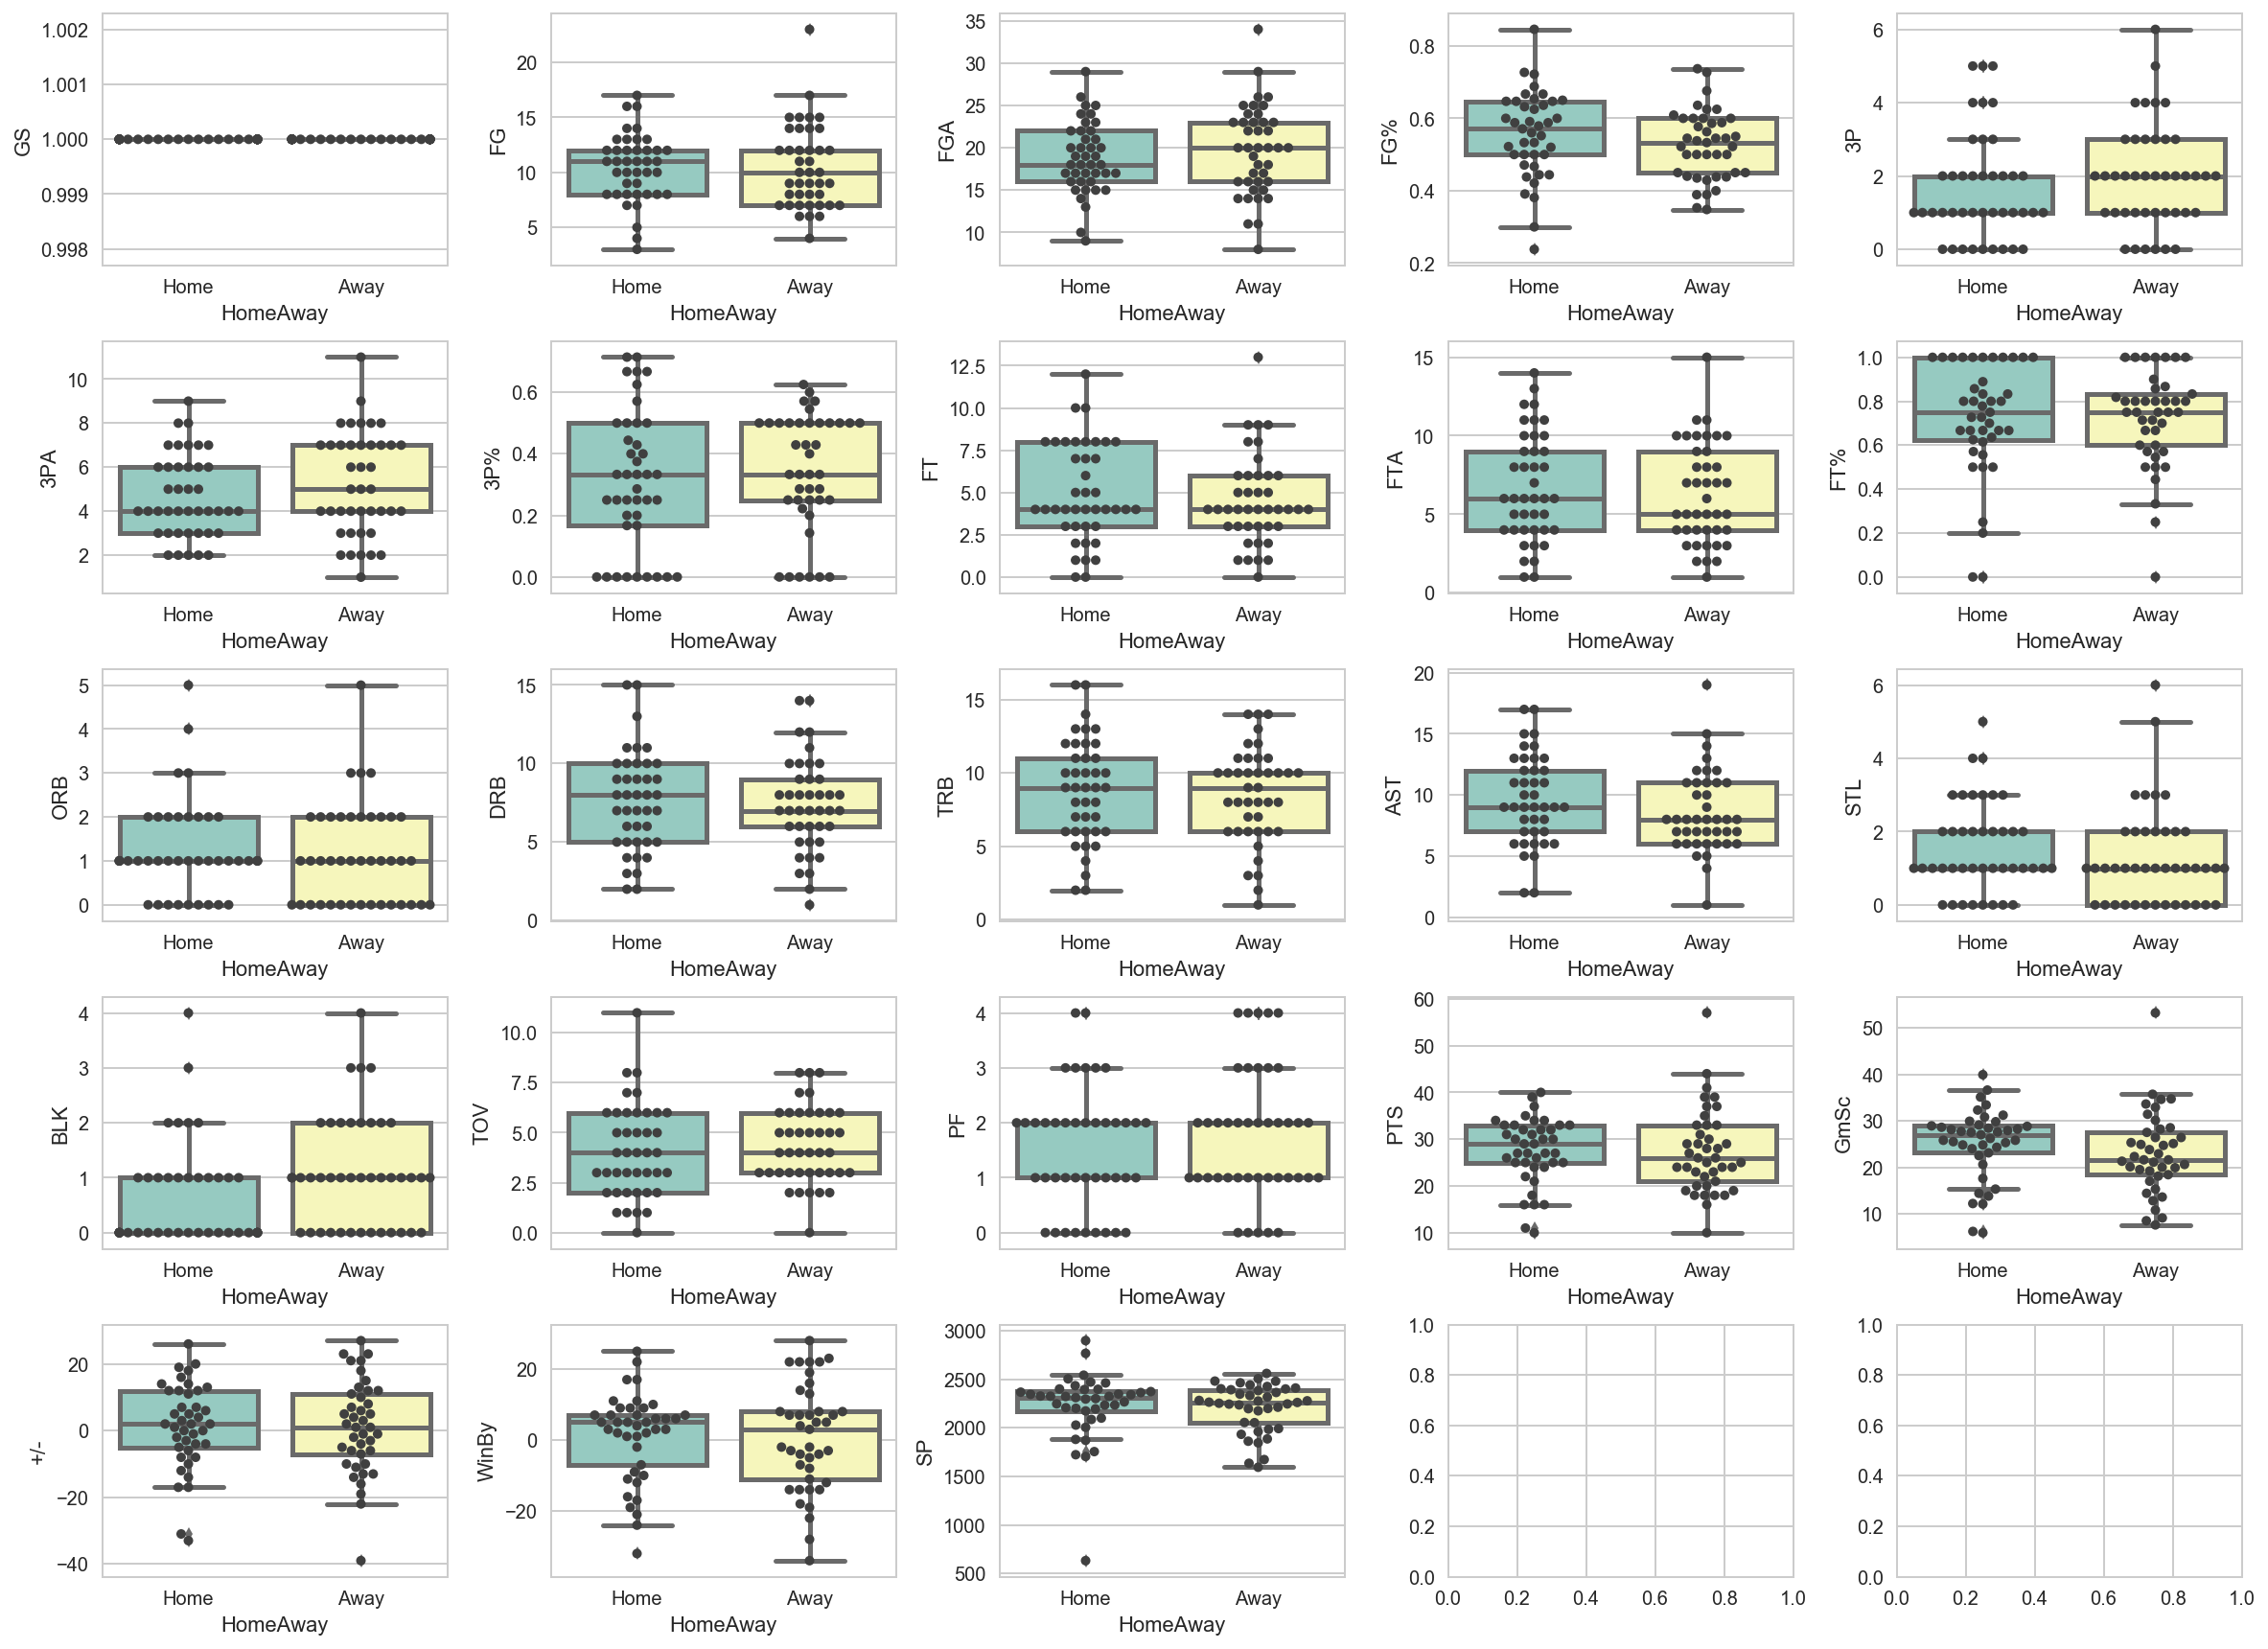

In [24]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,15))
fig.subplots_adjust(hspace =.3, wspace=.3)
axes = axes.ravel()
for i, col in enumerate(numeric_df.columns):
    _= sns.boxplot(y=col, x=df['HomeAway'], data=numeric_df, ax=axes[i], palette ="Set3", linewidth = 2.5)
    _= sns.swarmplot(y=col, x=df['HomeAway'], data=numeric_df, ax=axes[i], color='.25')

By observing the boxplots, Lebron plays better at home. The smaller boxplots represent that Lebron is more consistent at home. (since the 25%tile and 75%tile has a smaller range) There is further proof with the swamplot that the concentration of points are higher compared on the road. 

Let's take a few examples from each row. Lebron's FGA is lower compared on the road. We see a direct correlation via his FG%, since the number of FG made divided by FGA. 

Next, let's look at Rebounds. Interestingly Lebron is more consistent in offensive rebounds at Home but more consistent in defensive rebounds Away, but he still rebounds more compared to Away. 

Lastly, look at his +/-. This means the contribution every time Lebron James is on the court. Surprisingly, Lebron's average +/- during the regular season is 0. 

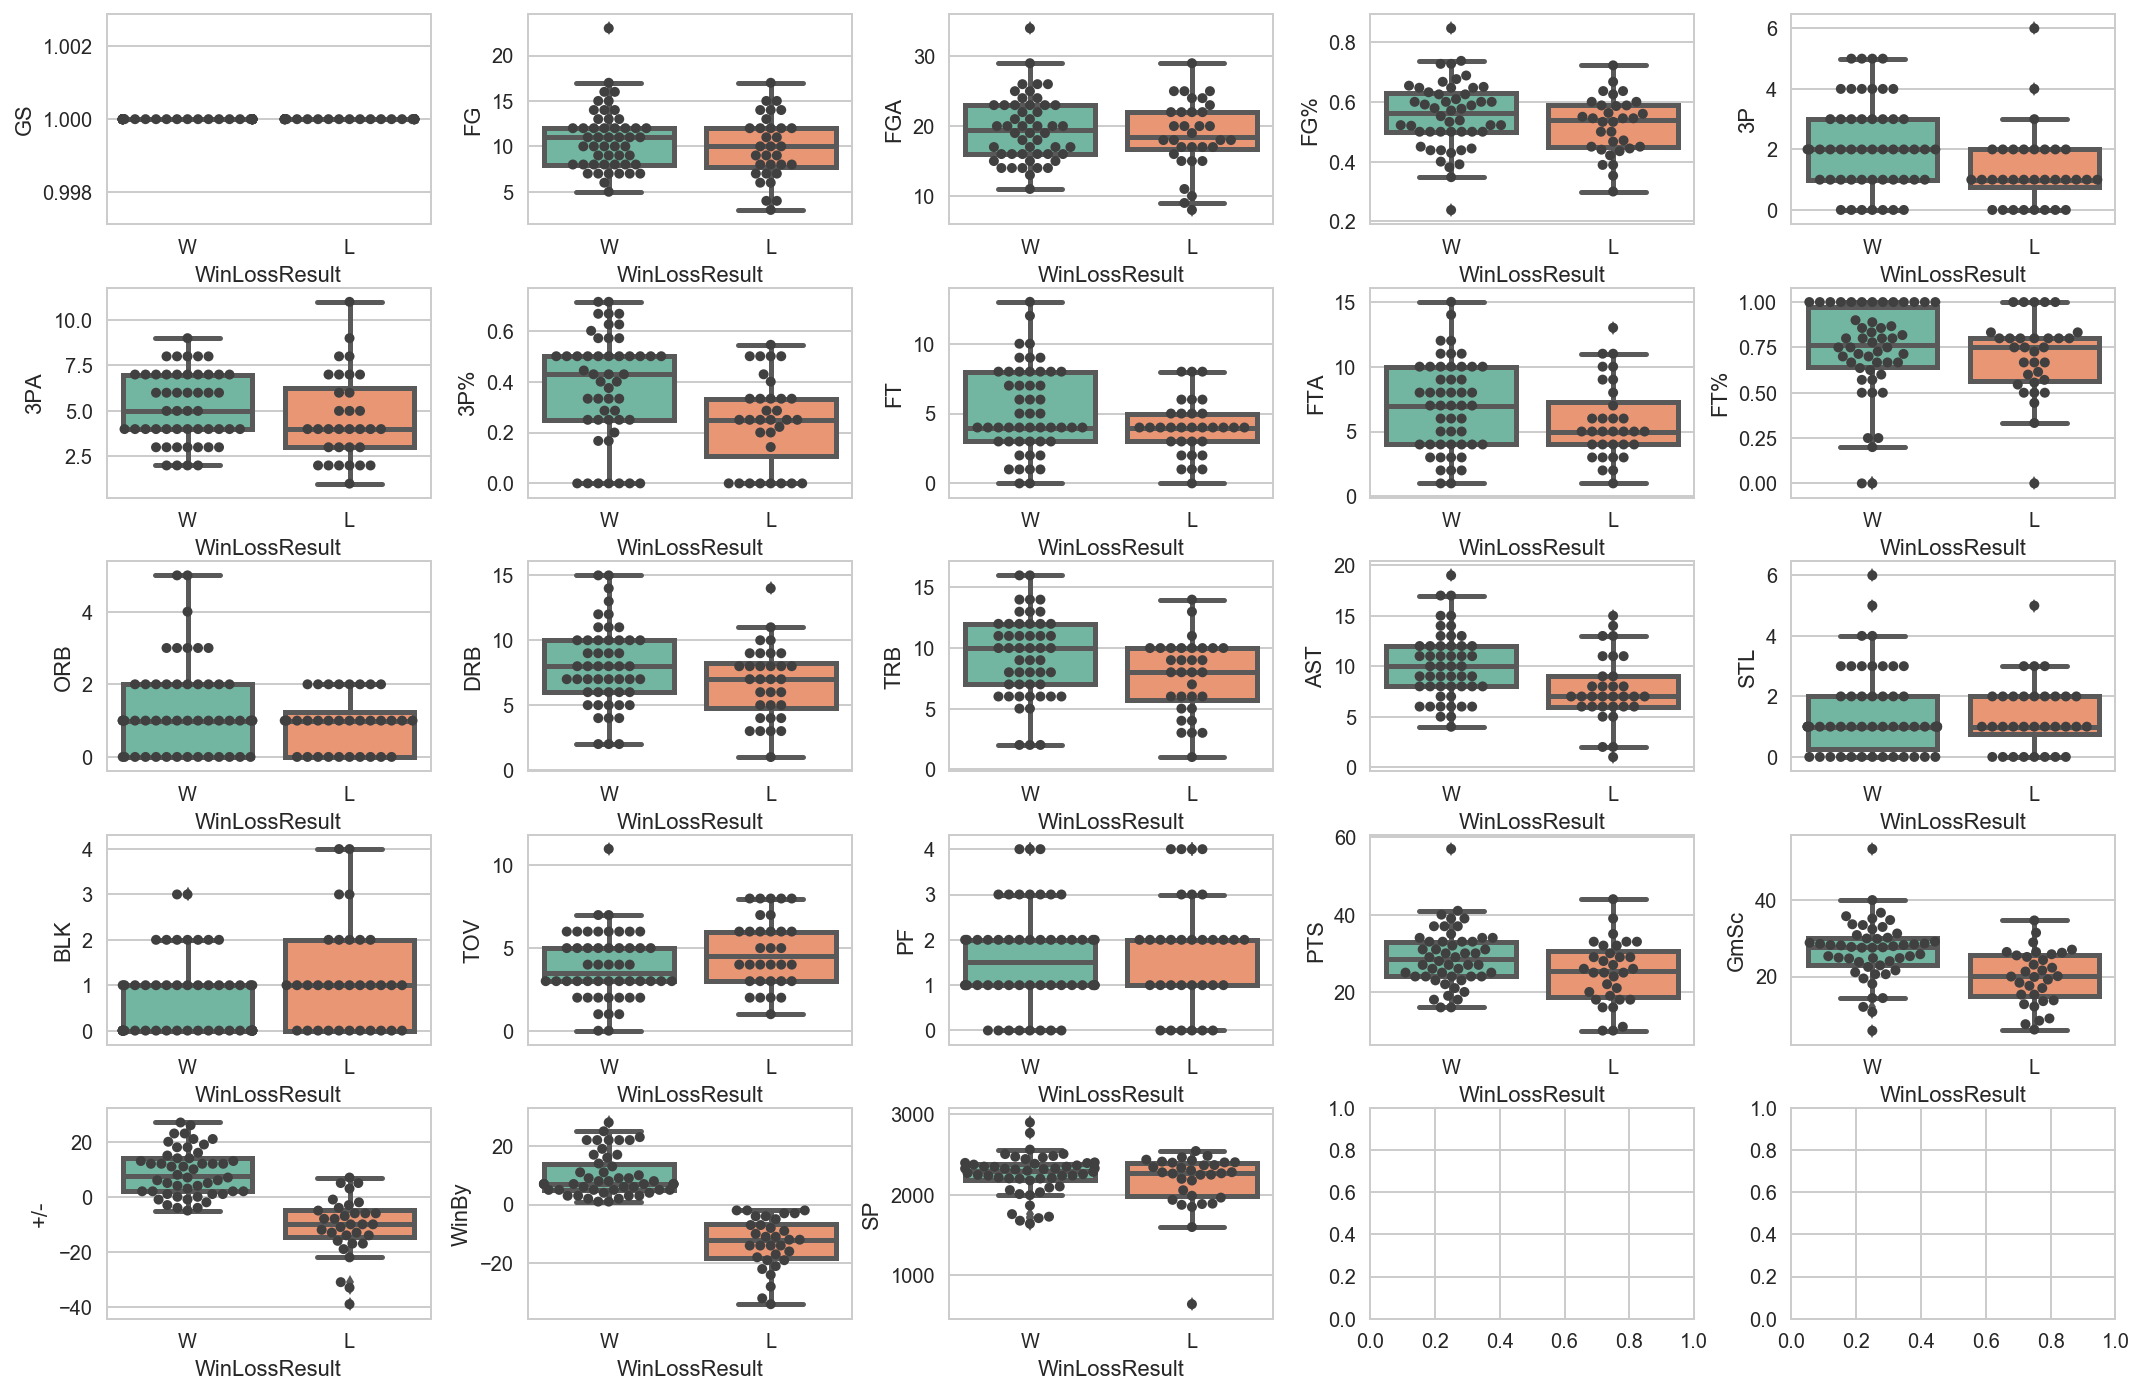

In [25]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(18,12))
fig.subplots_adjust(hspace =.3, wspace=.3)
axes = axes.ravel()
for i, col in enumerate(numeric_df.columns):
    _= sns.boxplot(y=col, x=df['WinLossResult'], data=numeric_df, ax=axes[i], palette ="Set2", linewidth = 2.5)
    _= sns.swarmplot(y=col, x=df['WinLossResult'], data=numeric_df, ax=axes[i], color='.25')

Obviously, when you lose, you typically play worse. Since Lebron is the publicly considered the Leader of the Cleveland Caviliers, let's analyze what Lebron needs to do for the Caviliers to take the **DUB**

Typically when Caviliers win, Lebron has higher FGA which corresponds to higher FG. Lebron is not much of 3P shooter, but when Cavs win, Lebron typically makes 2 3P and more 3PA. Also when the Cavs win, Lebron rebounds the ball more often and gives more assists. 

However we see that Lebron does not need BLKs and STLs as much and they'll still win

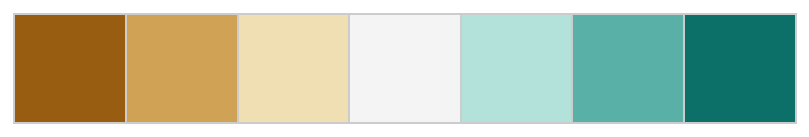

In [26]:
sns.palplot(sns.color_palette("BrBG", 7))
set1=[sns.color_palette("BrBG", 7)[0],sns.color_palette("BrBG", 7)[6]]

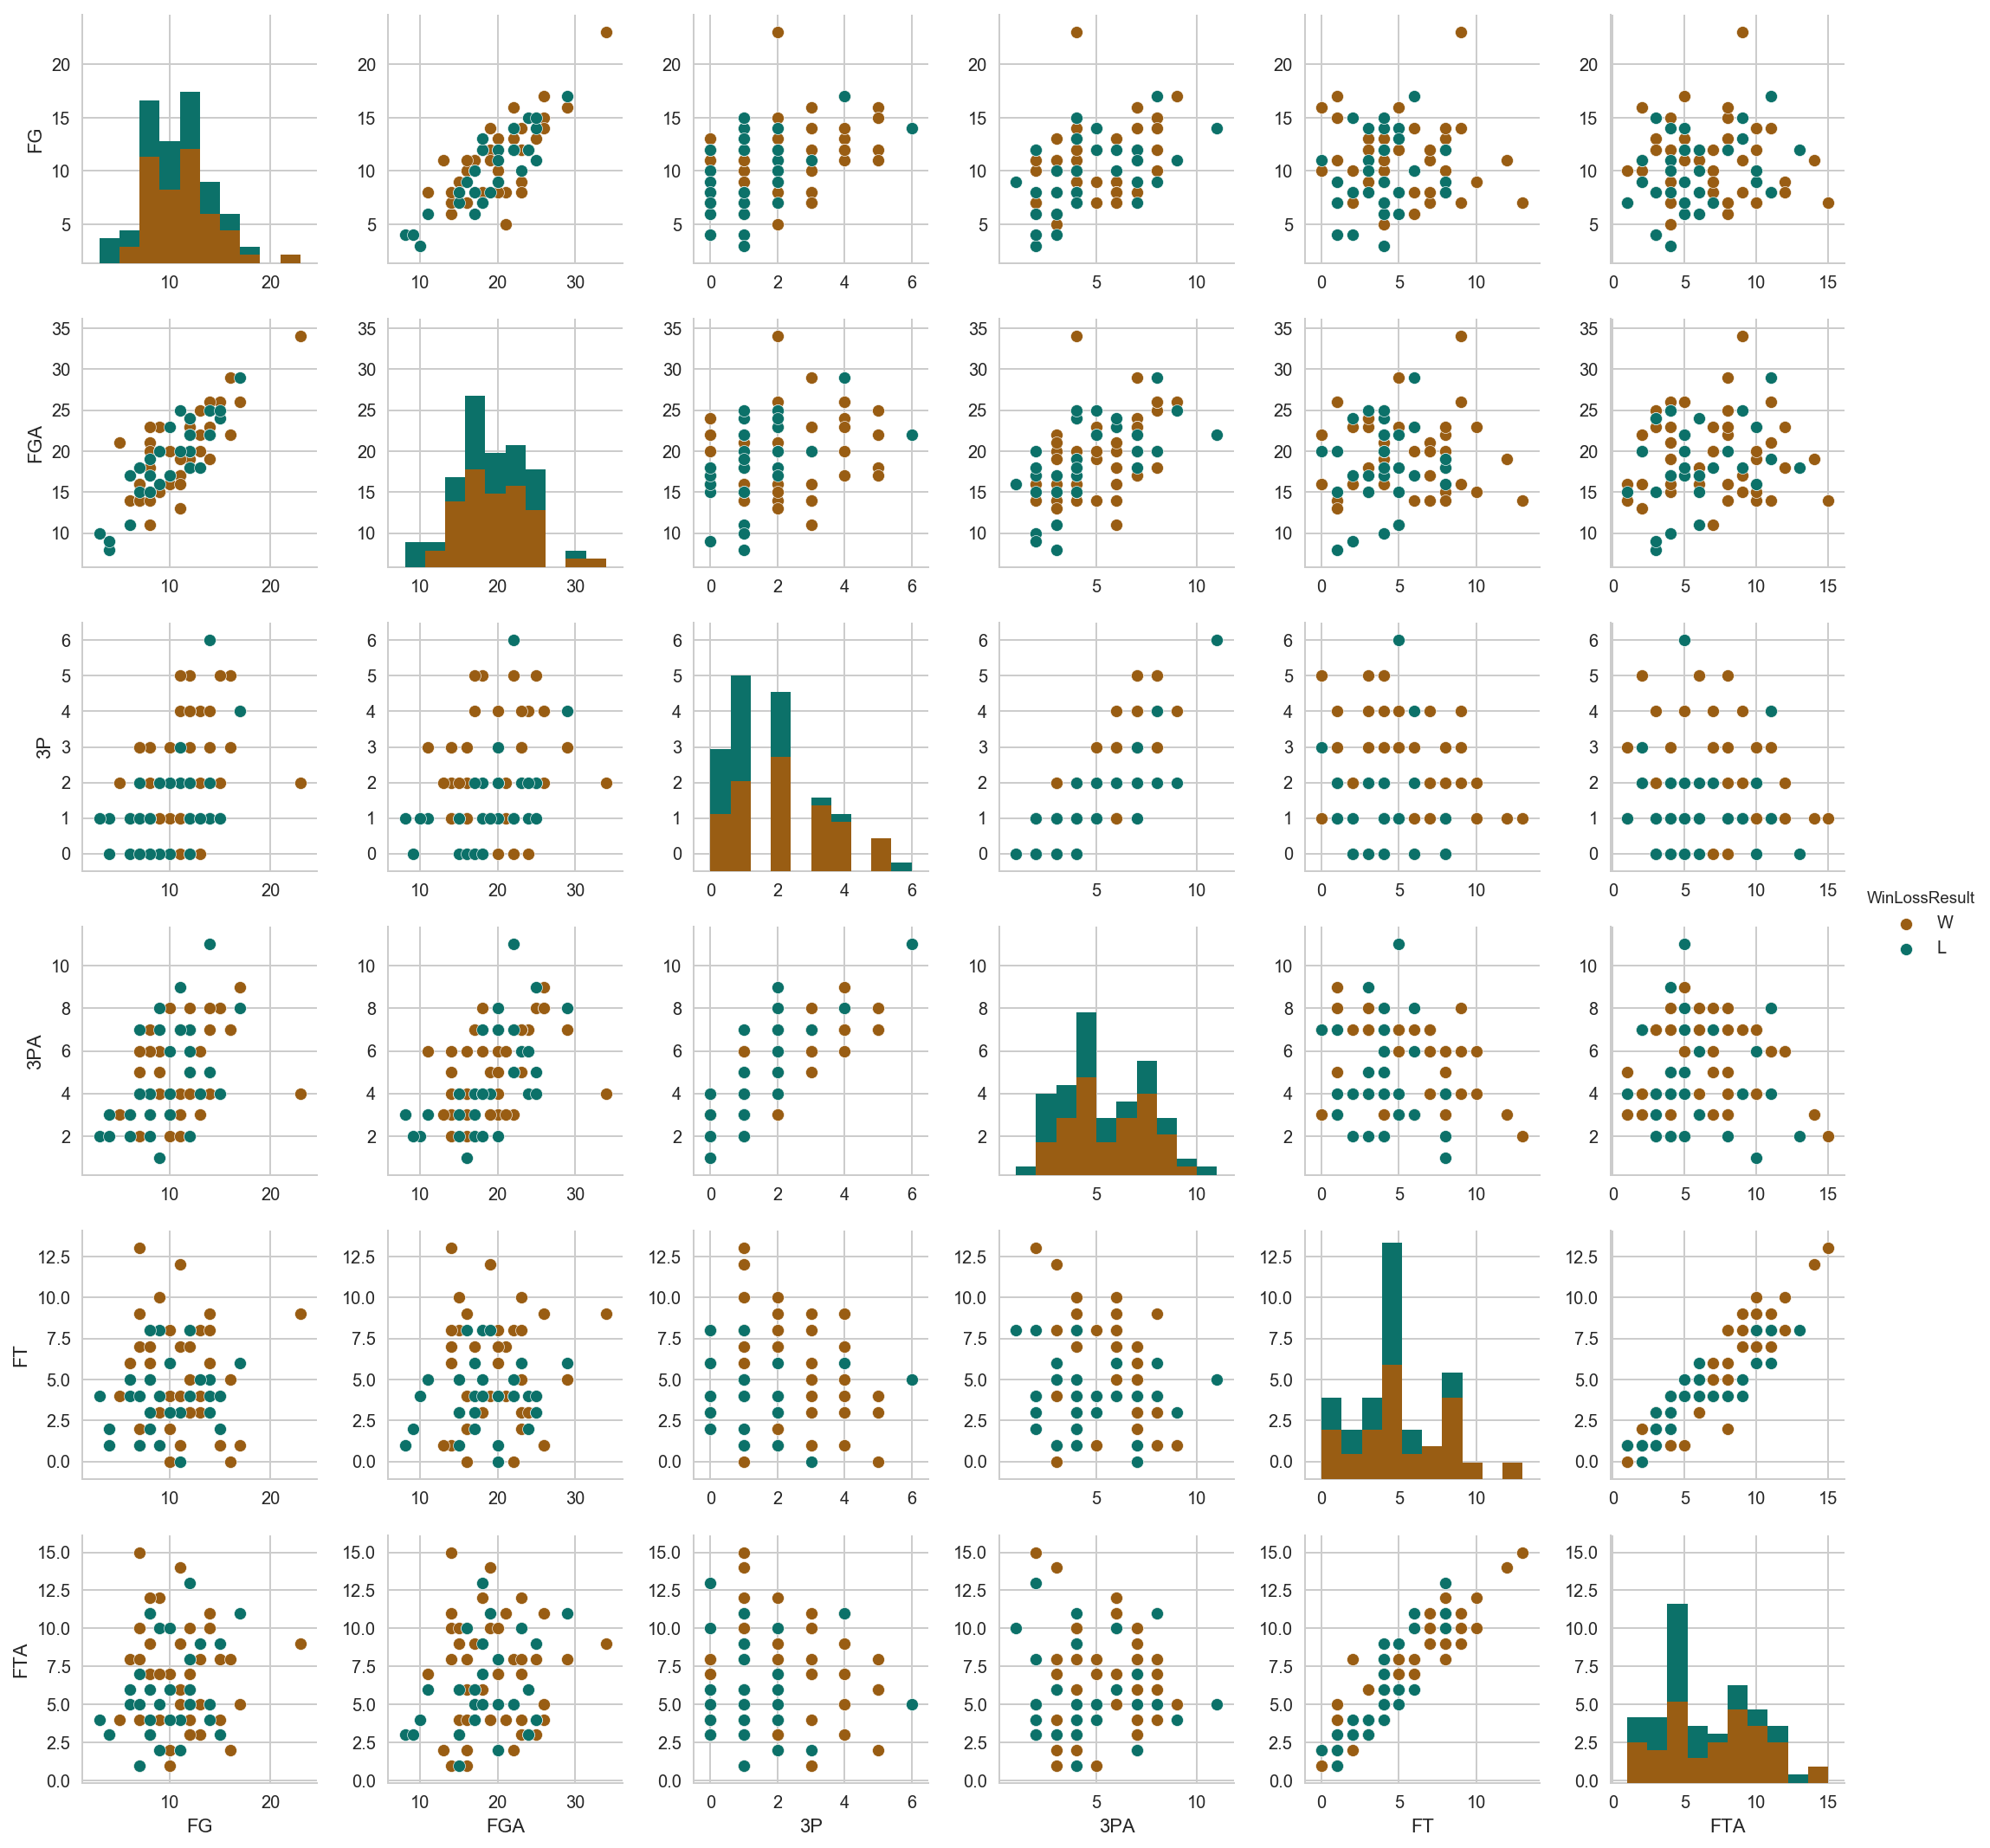

In [27]:
# simple offense pairplot
# with emphasis on shooting
offense_df = df[['FG','FGA','3P','3PA','FT','FTA','WinLossResult']]
sns.pairplot(offense_df, hue="WinLossResult", palette=set1);

Interstingly based on pairplot, Caviliers typically win when Lebron has fewer shots made. 

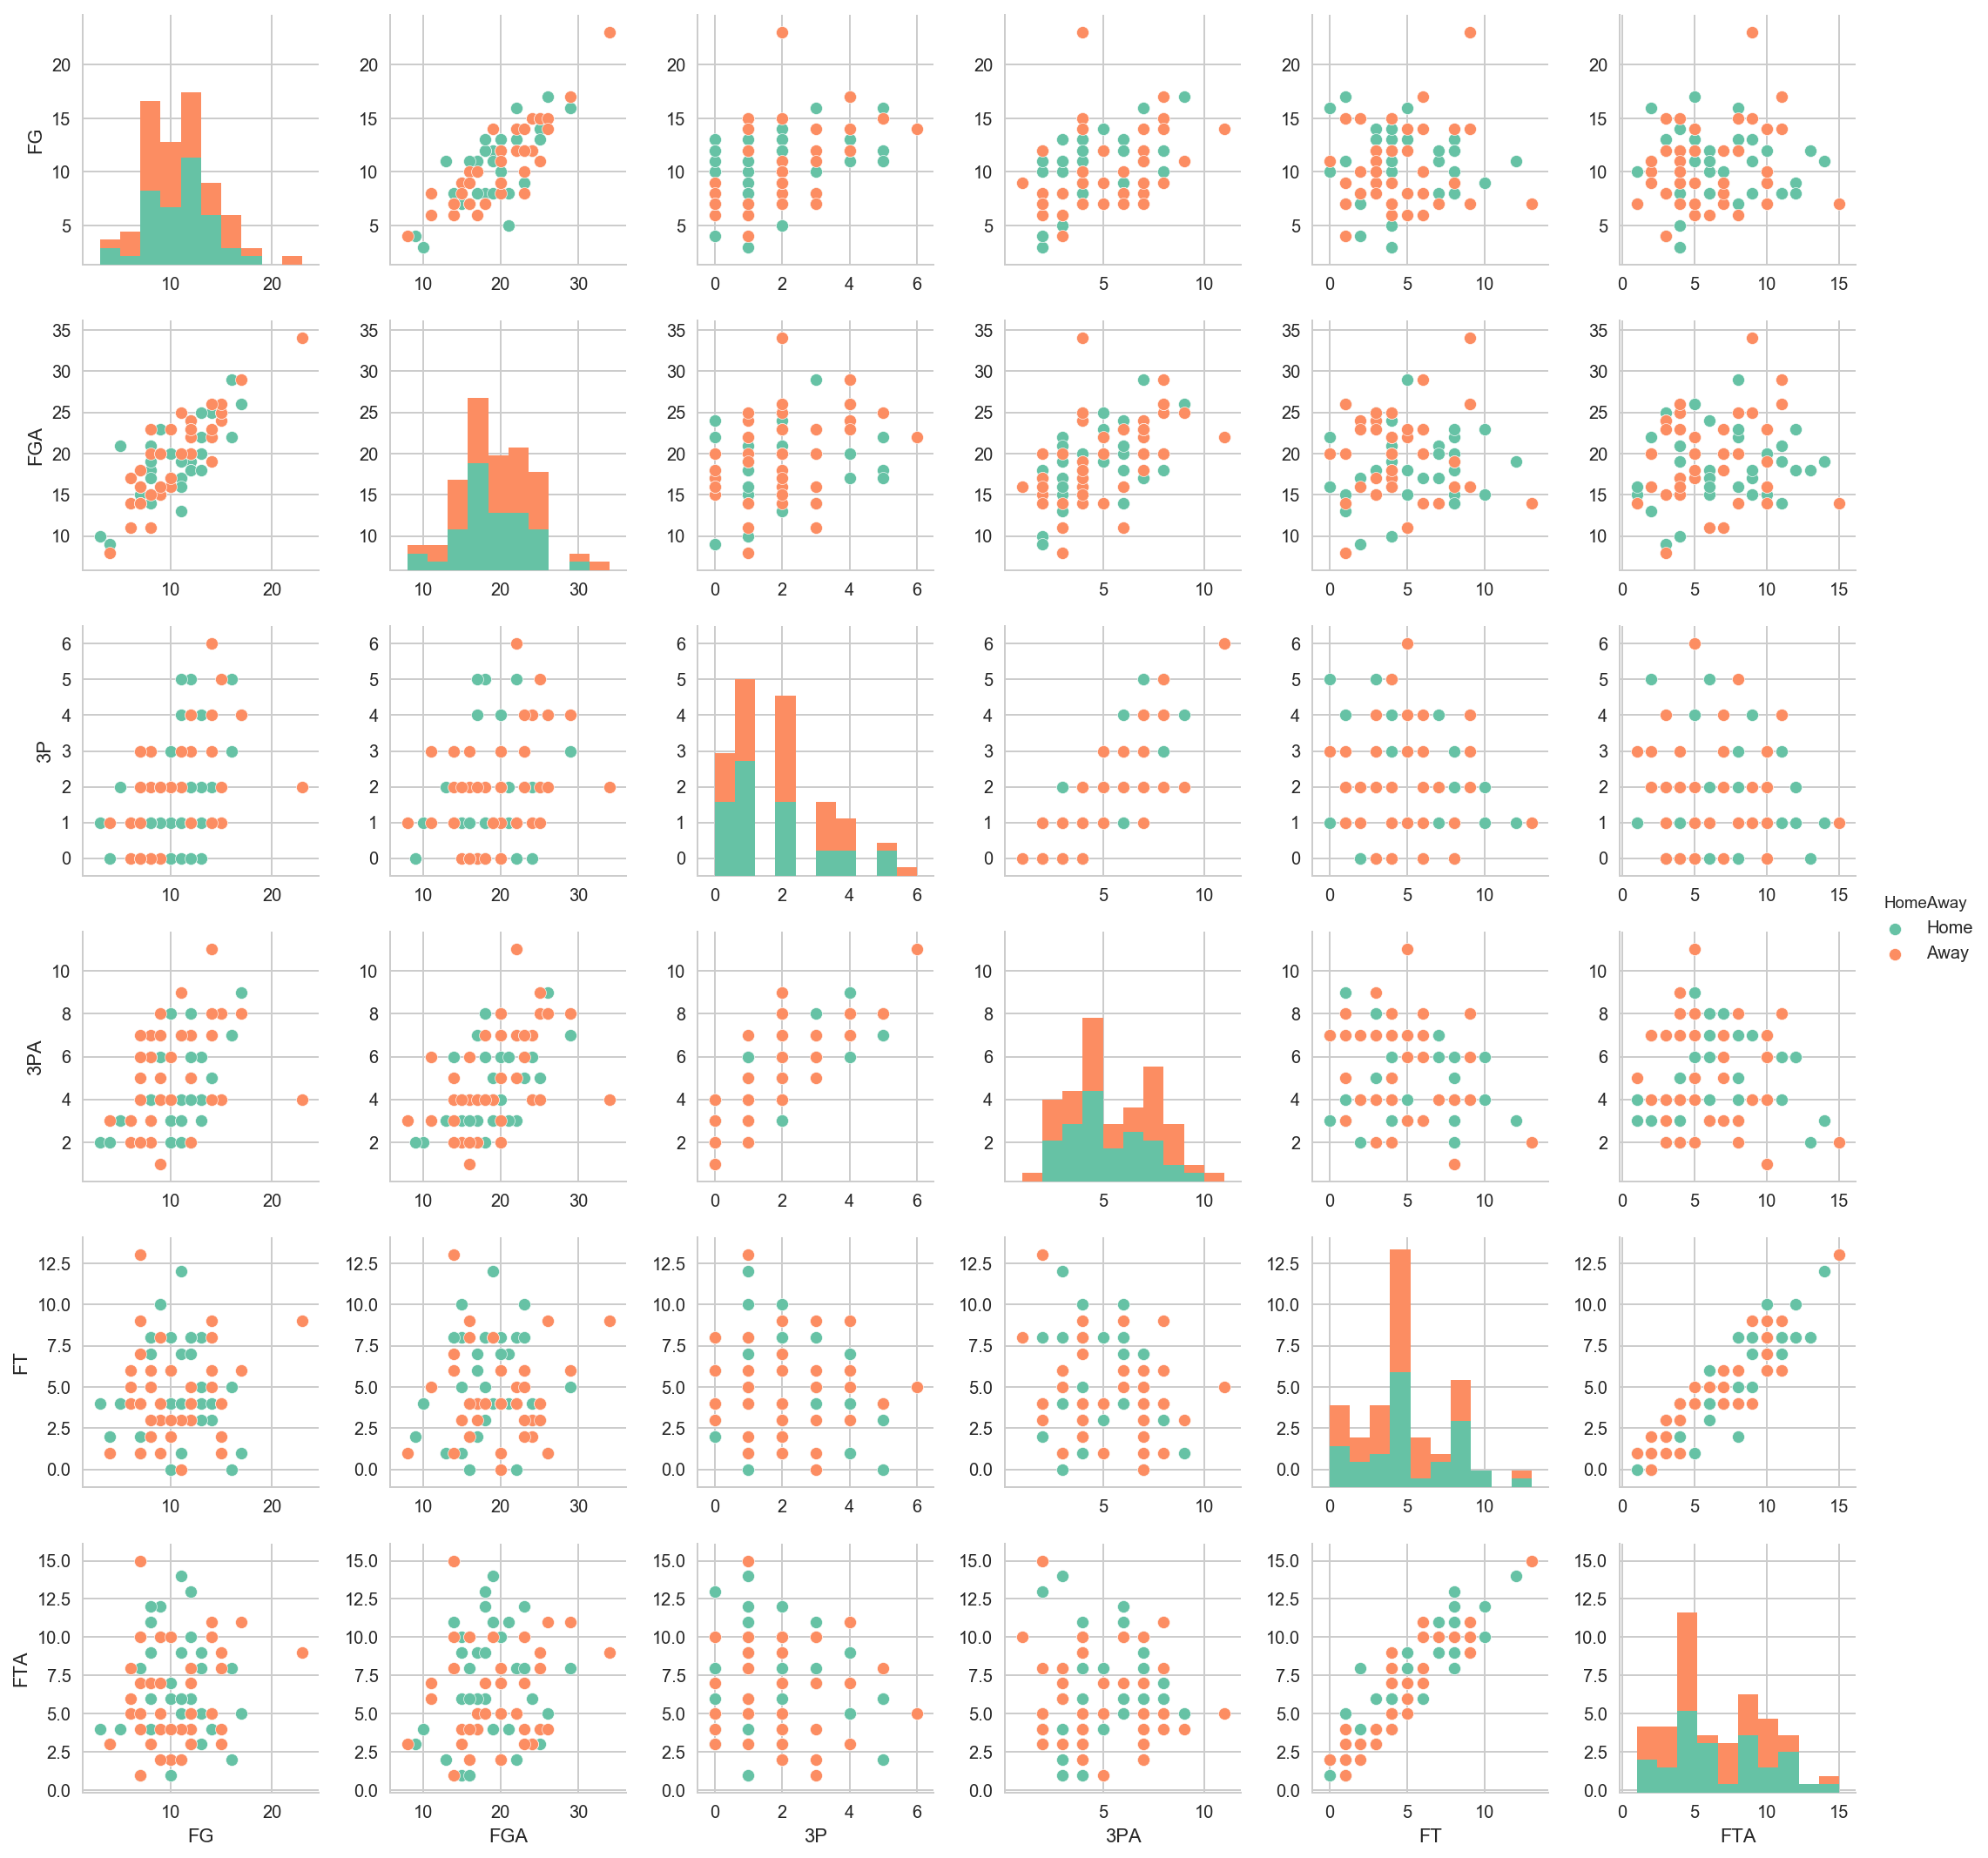

In [28]:
# simple offense pairplot
# with emphasis on shooting
offense_df = df[['FG','FGA','3P','3PA','FT','FTA','HomeAway']]
sns.pairplot(offense_df, hue="HomeAway", palette=sns.color_palette("Set2",2));

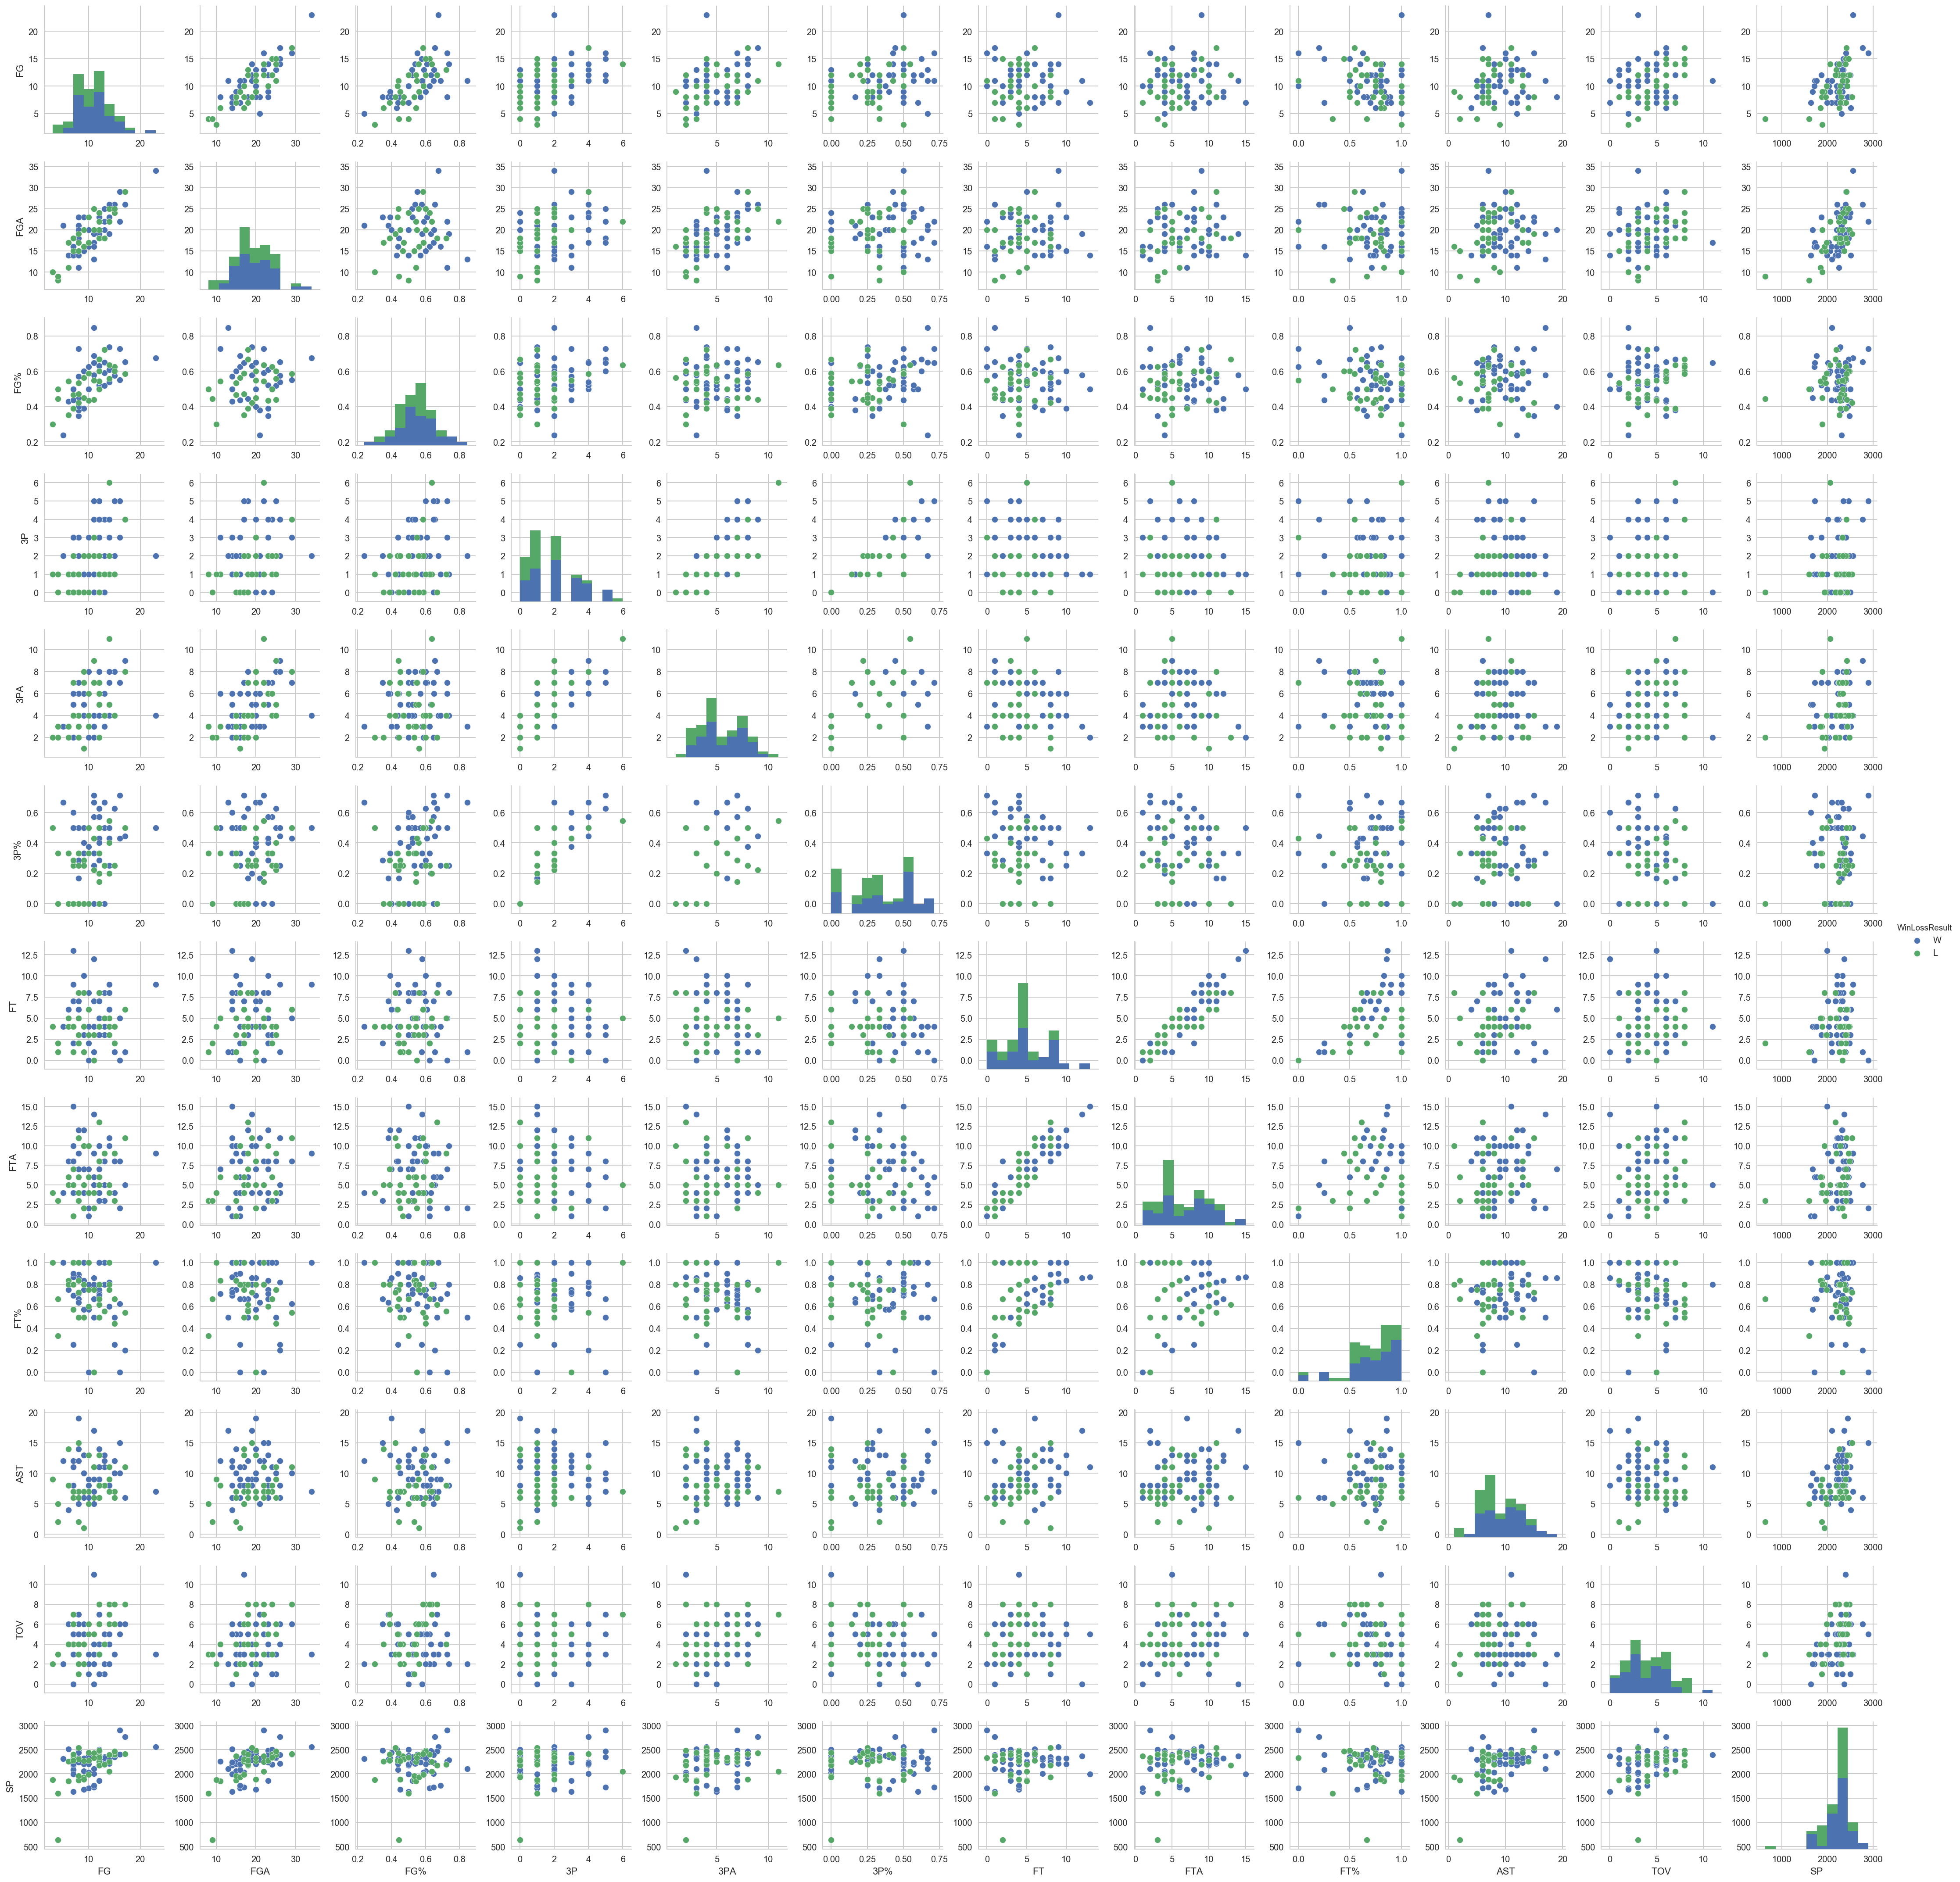

In [29]:
# offense 
# with emphasis on ball possession
offense = df[['FG','FGA','FG%','3P','3PA','3P%','FT','FTA','FT%','AST','TOV','SP','WinLossResult']]
sns.pairplot(offense,hue="WinLossResult");

In [30]:
# sns.palplot(sns.color_palette("RdBu_r", 7))
set2=[sns.color_palette("RdBu_r", 7)[0],sns.color_palette("RdBu_r", 7)[6]]

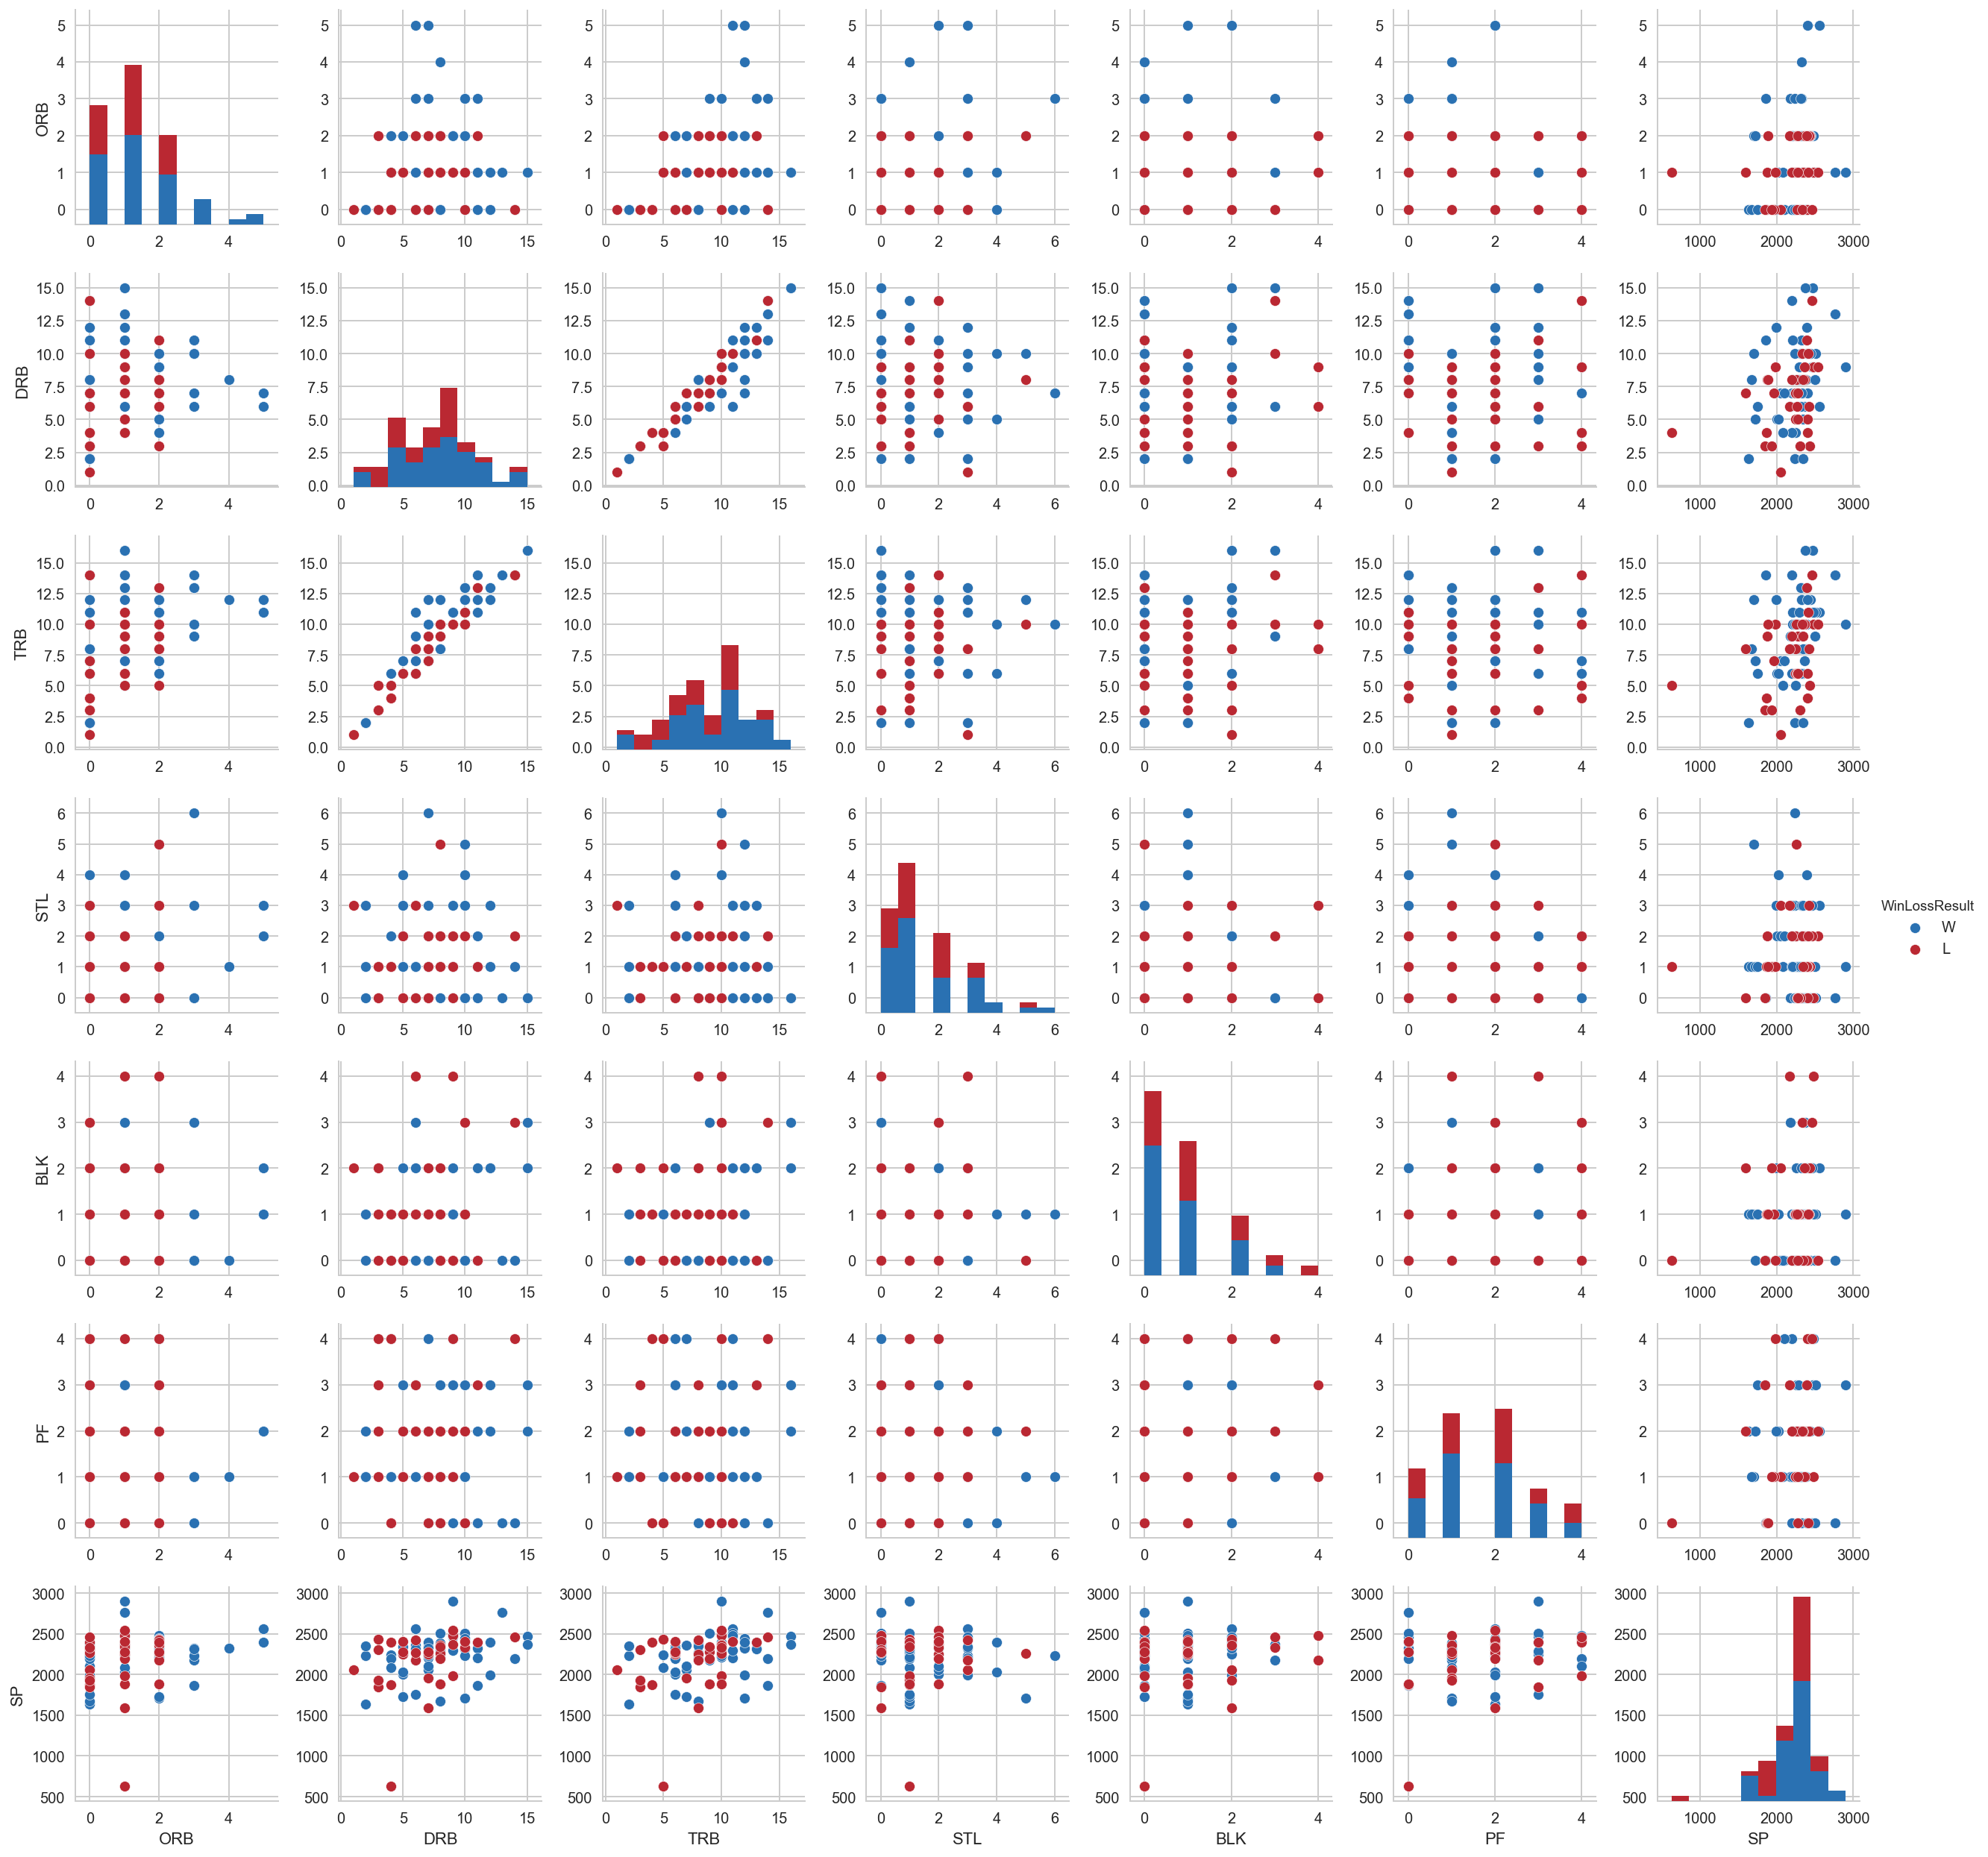

In [31]:
# defense
defense = df[['ORB','DRB','TRB','STL','BLK','PF','SP', 'WinLossResult']]
sns.pairplot(defense,hue="WinLossResult",palette=[sns.color_palette("RdBu_r", 7)[0],sns.color_palette("RdBu_r", 7)[6]]);

Similar result above, if Lebron has more rebounds, steals, blocks, etc. the Caviliers typically lose. This more than likely means that Lebron cannot carry his team when they're losing. When the Caviliers win, Lebron's stats are lower, because his team is supporting him better compared to when they lose. 

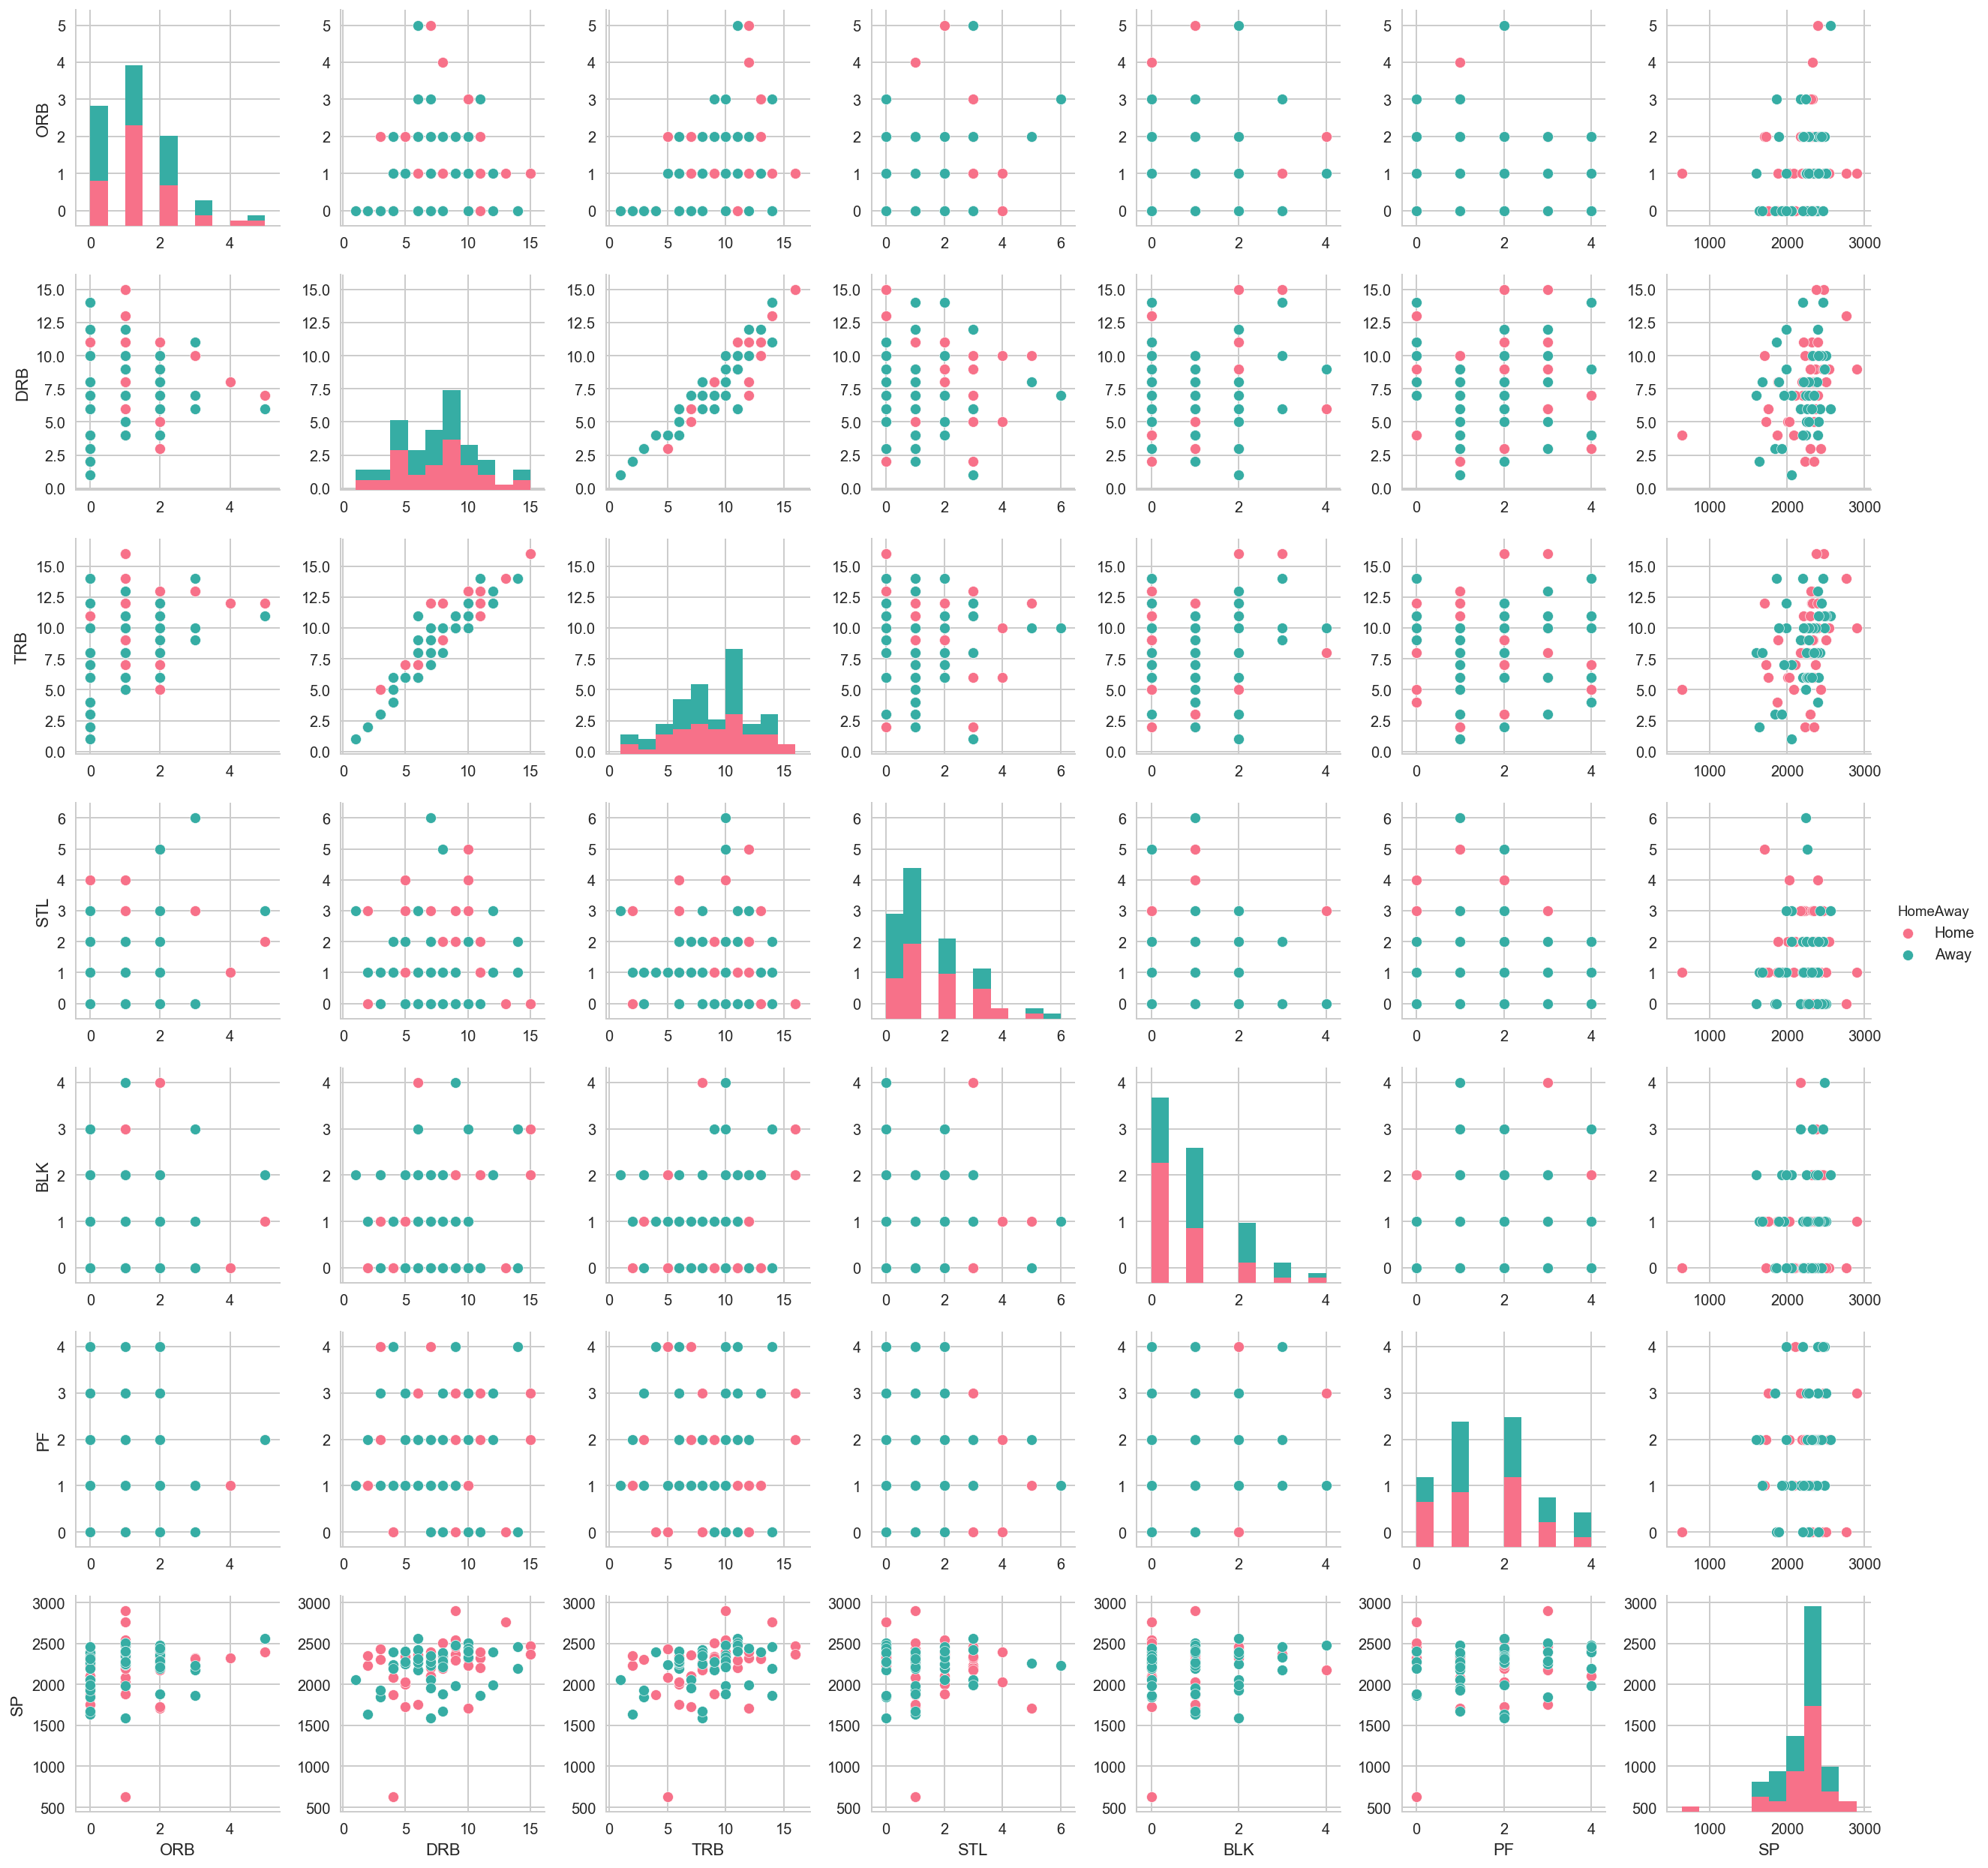

In [32]:
# defense
defense = df[['ORB','DRB','TRB','STL','BLK','PF','SP', 'HomeAway']]
sns.pairplot(defense,hue="HomeAway",palette=[sns.color_palette("husl")[0],sns.color_palette("husl")[3]]);

In [33]:
df=df.set_index('Date')

In [34]:
# averages per month for the regular season
df.groupby(by=[df.index.strftime("%B %Y")]).mean()

GS         FG        FGA       FG%        3P       3PA  \
April 2018     1.0   8.833333  18.166667  0.479500  2.333333  5.333333   
December 2017  1.0  10.142857  19.357143  0.534071  1.928571  5.571429   
February 2018  1.0  10.700000  19.600000  0.531400  1.800000  4.300000   
January 2018   1.0   9.071429  17.928571  0.512000  0.928571  4.214286   
March 2018     1.0  11.750000  21.312500  0.551750  2.000000  5.500000   
November 2017  1.0  11.466667  19.733333  0.575267  2.266667  5.266667   
October 2017   1.0   9.714286  16.571429  0.578857  1.571429  3.857143   

                    3P%        FT       FTA       FT%       ORB       DRB  \
April 2018     0.408833  6.000000  8.166667  0.756500  1.166667  7.833333   
December 2017  0.314429  5.285714  6.571429  0.777714  1.071429  7.142857   
February 2018  0.369300  3.800000  5.400000  0.708400  1.200000  9.300000   
January 2018   0.154429  4.428571  6.642857  0.670500  1.071429  6.214286   
March 2018     0.335188  5.437500  7.687500  0.655562  1.250000  8.312500   
November 2017  0.407067  4.400000  5.866667  0.715333  1.600000  7.066667   
October 2017   0.397571  3.571429  4.571429  0.852286  0.571429  6.571429   

                     TRB        AST       STL       BLK       TOV        PF  \
April 2018      9.000000   9.333333  0.666667  0.166667  4.666667  1.166667   
December 2017   8.214286  10.285714  1.928571  0.785714  4.928571  1.500000   
February 2018  10.500000  10.500000  1.000000  0.400000  3.700000  1.700000   
January 2018    7.285714   7.357143  1.785714  1.142857  4.714286  1.285714   
March 2018      9.562500   9.500000  1.312500  0.812500  3.687500  1.937500   
November 2017   8.666667   8.466667  1.466667  1.200000  4.000000  2.000000   
October 2017    7.142857   8.571429  1.000000  1.142857  4.000000  1.571429   

                     PTS       GmSc       +/-     WinBy           SP  
April 2018     26.000000  21.300000  9.333333  3.500000  2039.666667  
December 2017  27.500000  24.535714  3.000000  3.285714  2284.428571  
February 2018  27.000000  24.800000  0.400000  0.400000  2238.700000  
January 2018   23.500000  18.814286 -7.071429 -6.214286  2160.714286  
March 2018     30.937500  27.256250  3.187500  2.437500  2239.312500  
November 2017  29.600000  26.460000  5.733333  6.133333  2222.333333  
October 2017   24.571429  22.000000 -5.428571 -5.428571  2217.142857

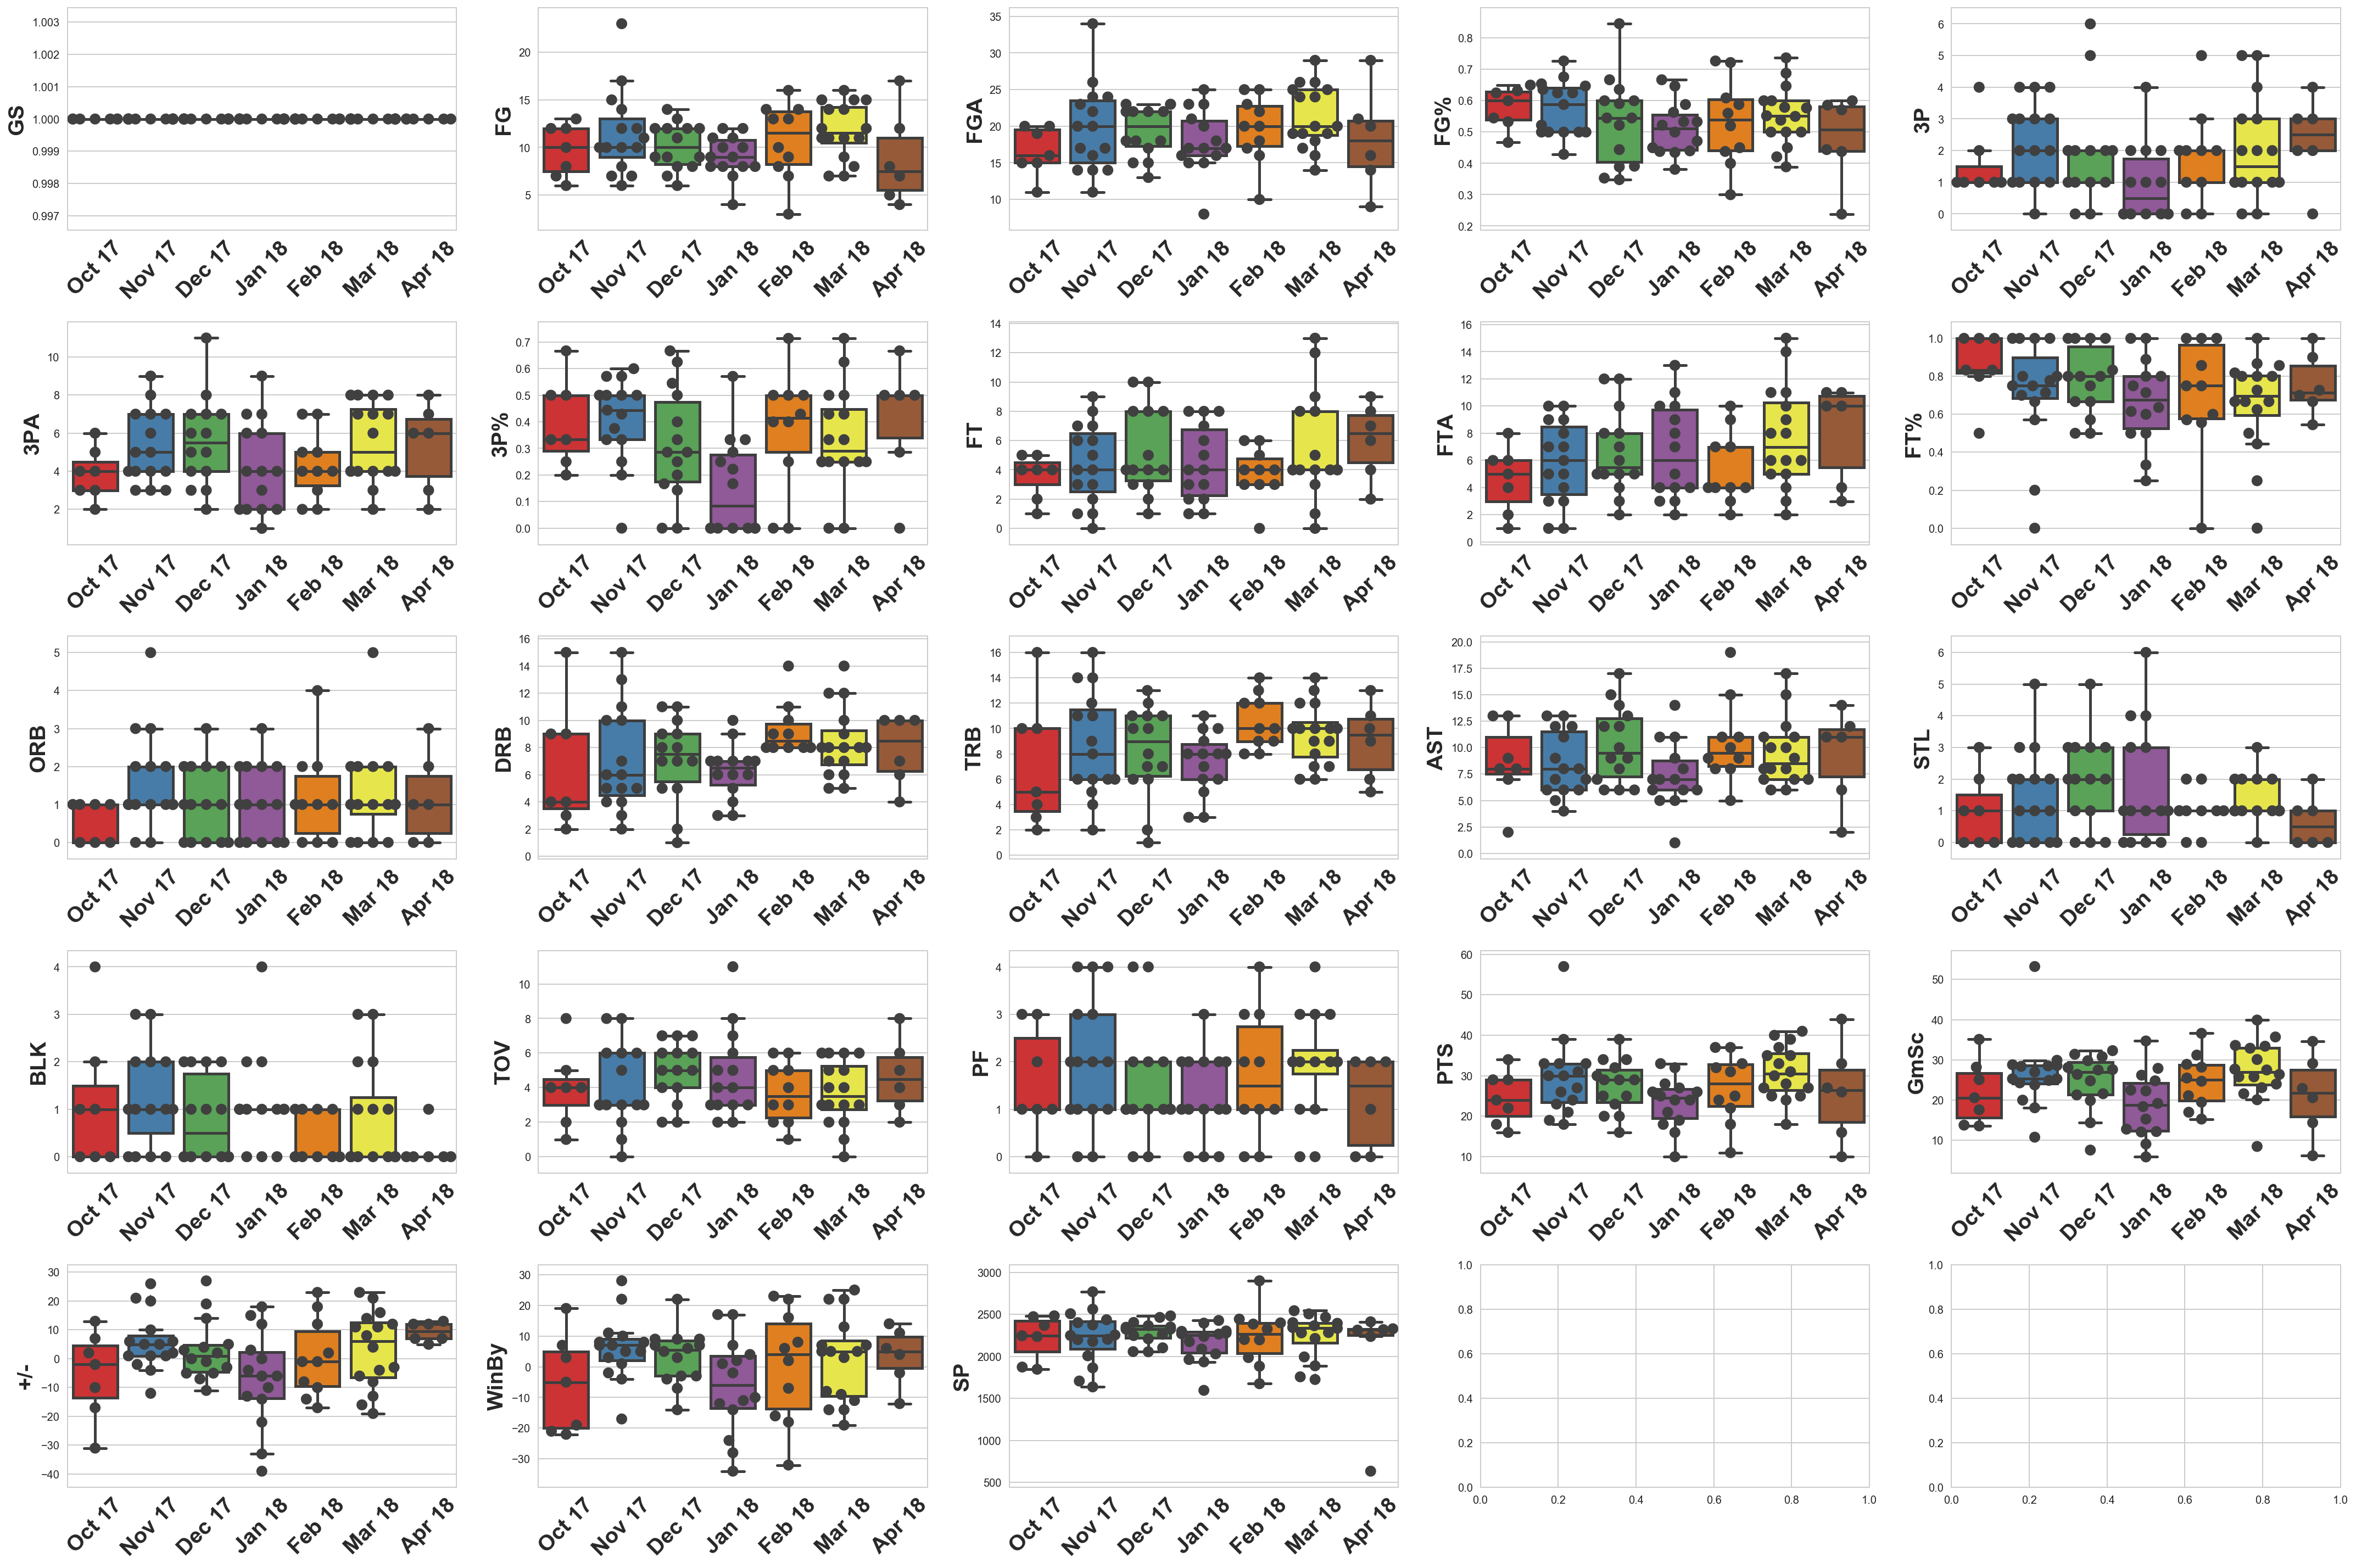

In [35]:
# visual of Lebron's averages for regular season
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(30,20))
fig.subplots_adjust(hspace =.3, wspace=.3)
axes = axes.ravel()
for i, col in enumerate(numeric_df.columns):
    g= sns.boxplot(y=col, x=df.index.strftime("%b %y"), data=numeric_df, ax=axes[i], palette ="Set1", linewidth = 2.5)
    g= sns.swarmplot(y=col, x=df.index.strftime("%b %y"), data=numeric_df, ax=axes[i], color='.25',size=10)
    g.set_xticklabels(g.get_xticklabels(), rotation=45,size=20,fontweight='bold')
    g.set_ylabel(g.get_ylabel(),size=20,fontweight='bold')
plt.tight_layout();

In [36]:
regular_season_record=df.groupby(by=[df.index.strftime("%b %y"),'WinLossResult'],sort=False)['WinBy'].count()
regular_season_record

        WinLossResult
Oct 17  W                 3
        L                 4
Nov 17  L                 3
        W                12
Dec 17  W                 9
        L                 5
Jan 18  W                 6
        L                 8
Feb 18  L                 4
        W                 6
Mar 18  L                 6
        W                10
Apr 18  W                 4
        L                 2
Name: WinBy, dtype: int64

The above boxplots represent the Lebron's monthly production

Let's examine Lebron's offense effectiveness. The stats that represent offense is **FG, 3P, FT, AST, STL, ORB**, etc. **Note**: you can argue that a lot of other stats can convert to offense as well. For example, defense rebounds can lead to fast break points, but for simplicity sake, let's just examine the above. 

We must also cross examine this with the games he's winning and losing in. Instead of using a hue this time, I used a groupBy to correspond the Month Year of Lebron's averages with Monthly Caviliers record.

For **FG**, we see that Lebron is pretty consistent on average until Feburary, where he is scoring a few more field goals. However in April, his field goal output is lower. Note there are months like Novemeber, where Lebron had a few games where his FG were above average. 

Let's take another example, such as **STL**, on average Lebron averages about 1 steal per game per month. Some months like January, Lebron had a game where he had 6 steals, which shot up his averages. We can manually extract to examine his stats for that particular game (since his steal value was high) 

**TLDR** Lebron is a consistent and dominant player and these statistics support him. 

In [37]:
df[df['STL']>5]

HomeAway  Opp  GS        MP  FG  FGA    FG%  3P  3PA    3P%  FT  \
Date                                                                         
2018-01-06     Away  ORL   1  37:17:00  12   23  0.522   4    7  0.571   5   

            FTA    FT%  ORB  DRB  TRB  AST  STL  BLK  TOV  PF  PTS  GmSc  +/-  \
Date                                                                            
2018-01-06    7  0.714    3    7   10    9    6    1    3   1   33  34.7   15   

           WinLossResult  WinBy    SP  
Date                                   
2018-01-06             W      4  2237

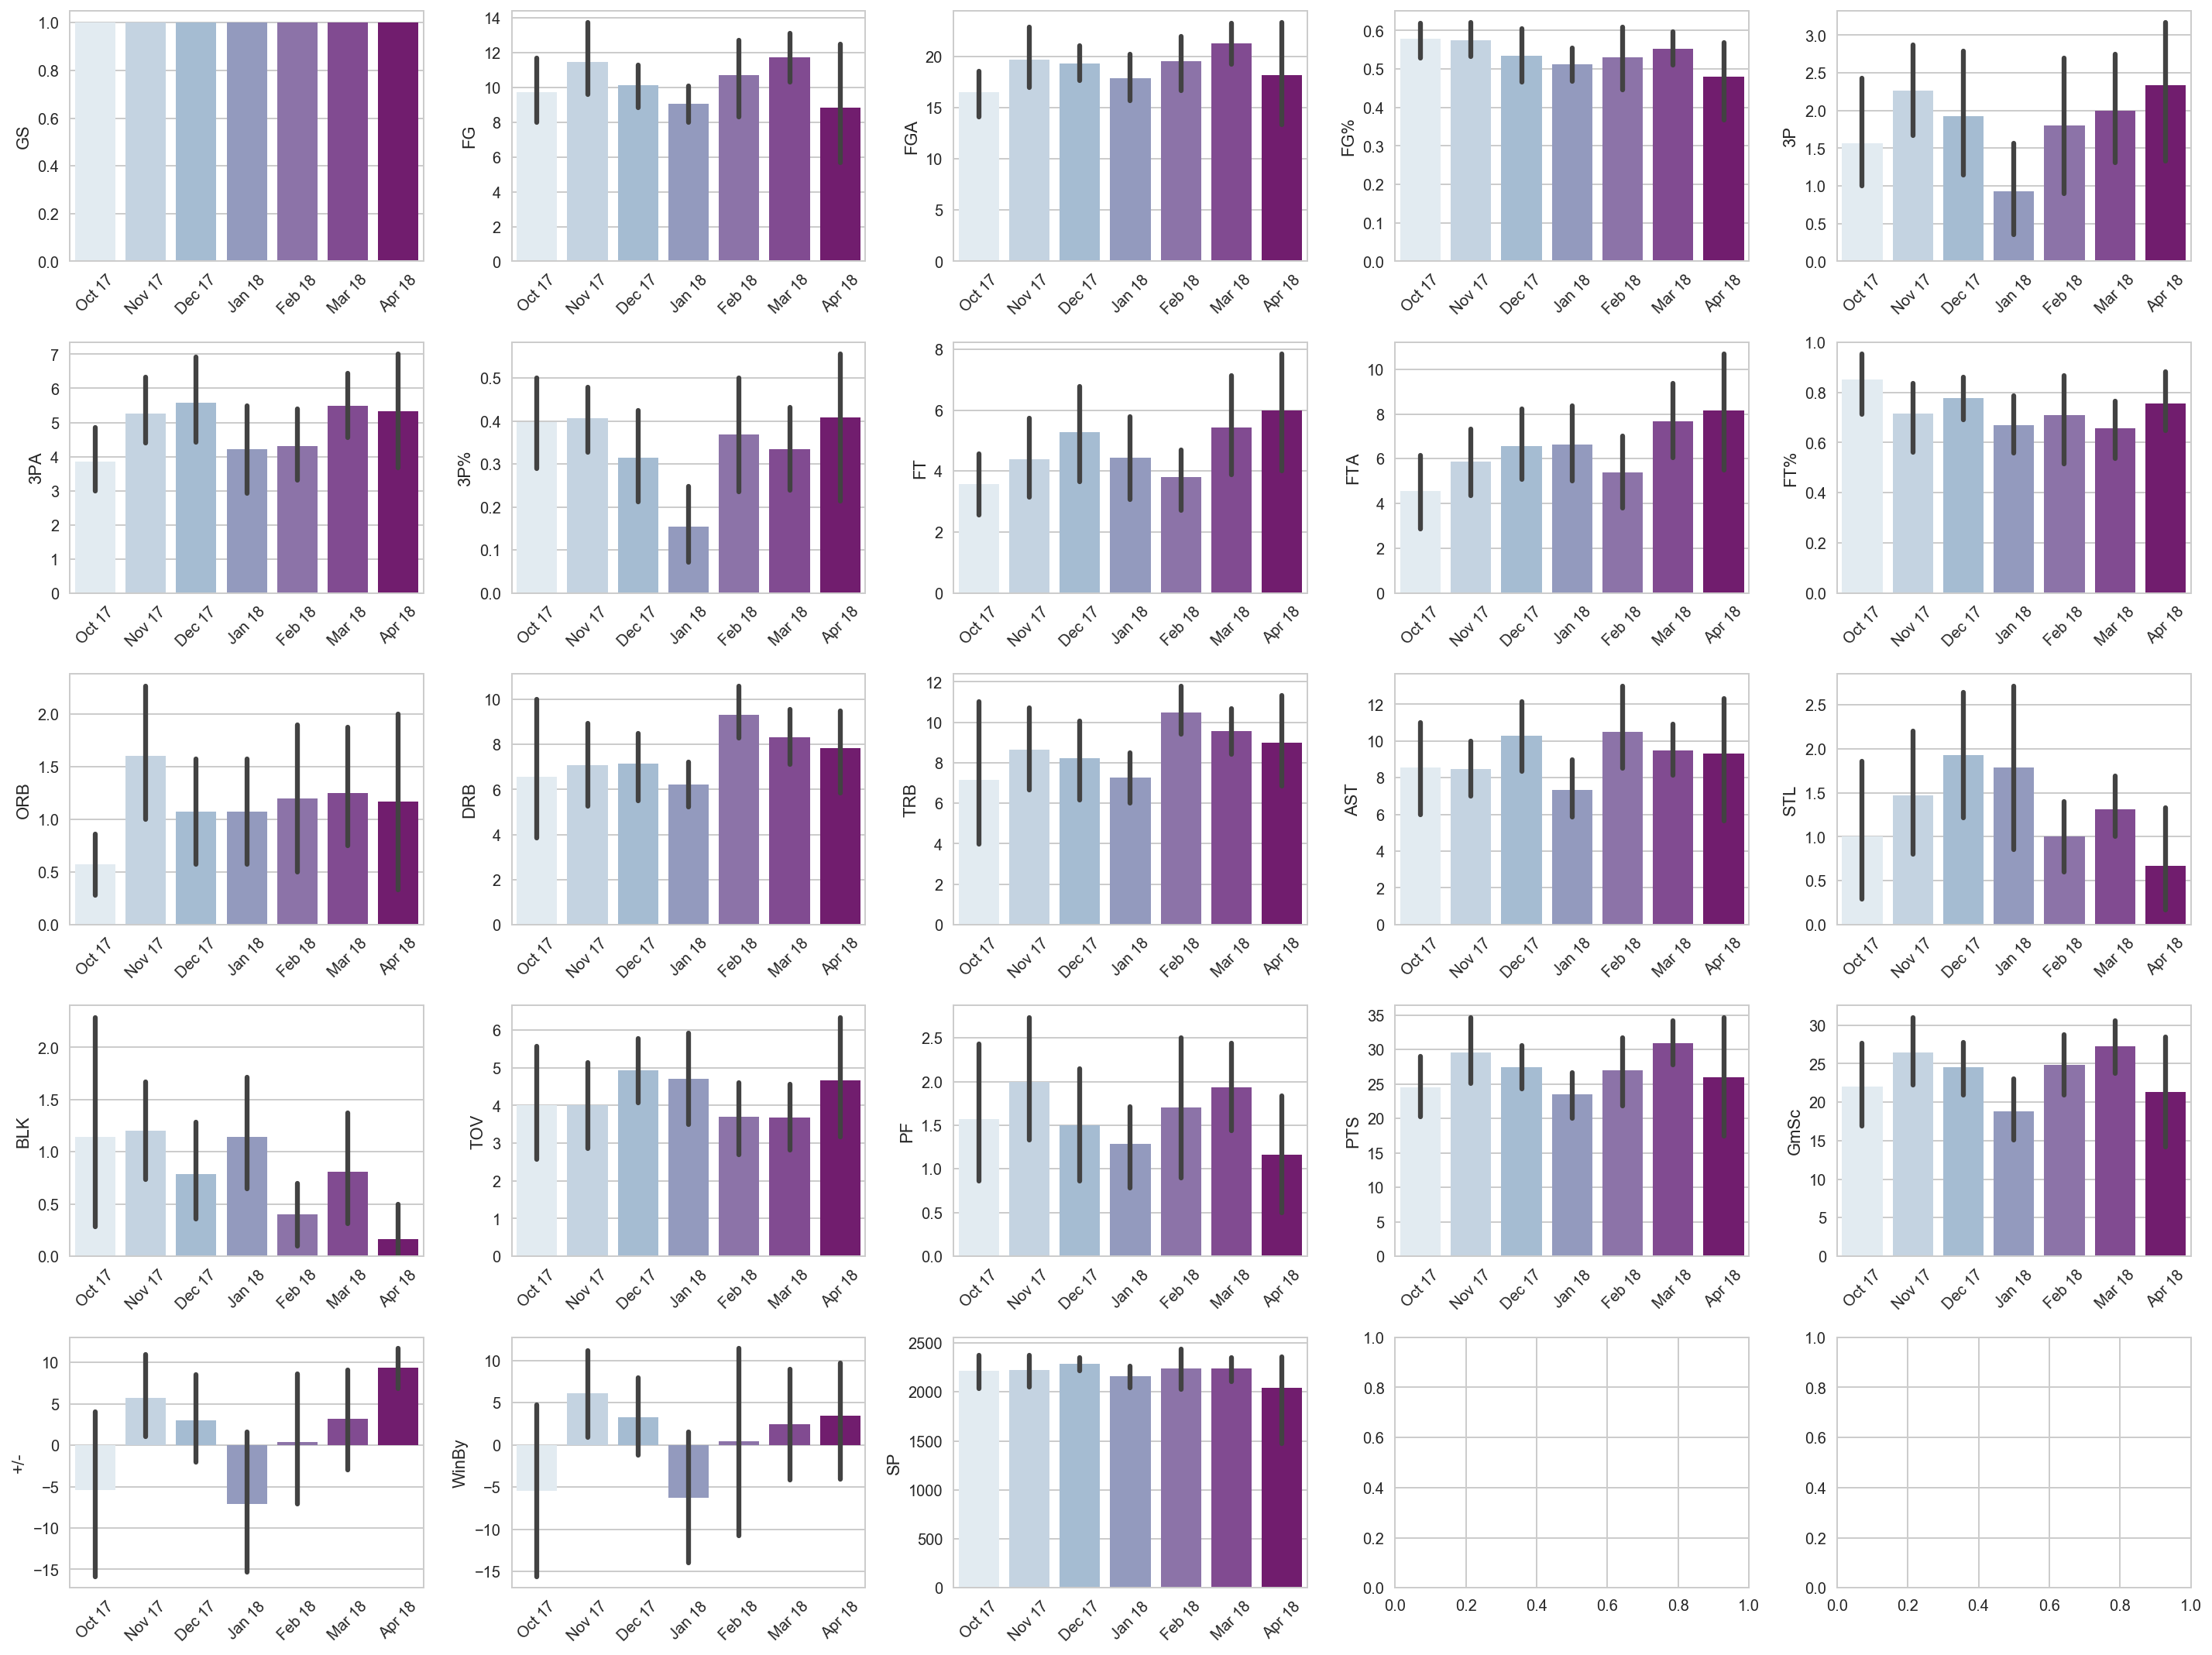

In [38]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,15))
fig.subplots_adjust(hspace =.3, wspace=.3)
axes = axes.ravel()
for i, col in enumerate(numeric_df.columns):
    g= sns.barplot(y=col, x=df.index.strftime("%b %y"), data=numeric_df, ax=axes[i], palette ="BuPu", linewidth = 2.5)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.tight_layout();


## Ideas

Analyze after Isaiah Thomas, Dwyane Wade, Derrick Rose, Jae Crowder trade (did not play 02-07-2018)

In [39]:
from collections import Counter
Counter(df['Opp'])

Counter({u'ATL': 4,
         u'BOS': 3,
         u'BRK': 4,
         u'CHI': 4,
         u'CHO': 3,
         u'DAL': 2,
         u'DEN': 2,
         u'DET': 4,
         u'GSW': 2,
         u'HOU': 2,
         u'IND': 4,
         u'LAC': 2,
         u'LAL': 2,
         u'MEM': 2,
         u'MIA': 3,
         u'MIL': 4,
         u'MIN': 2,
         u'NOP': 2,
         u'NYK': 4,
         u'OKC': 2,
         u'ORL': 4,
         u'PHI': 4,
         u'PHO': 2,
         u'POR': 2,
         u'SAC': 2,
         u'SAS': 2,
         u'TOR': 3,
         u'UTA': 2,
         u'WAS': 4})